# Análises estatísticas

A partir de várias análises estatísticas iremos entender melhor os dados assim como gerar possíveis insights.

# 1. Conhecendo os dados

Iremos conhecer os atributos dos dados assim como outras estatísticas básicas.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
#Setando diretorio Data como o atual
os.chdir('../Data')

#Leitura dos dados
df_parkinson = pd.read_csv('parkinson_v1.csv',index_col='name')

#Apresentacao dos dados
df_parkinson.head()

pse  pspf1  pspf2  pspf3           psp1          psp2  \
name                                                                   
person_0  3.021855      1      8     17   17243.324518   1850.713750   
person_0  3.533303      1      3      6   39115.767987  13796.968242   
person_0  0.859185      1      4     13  129866.558198   3193.568772   
person_0  3.424263      1      4      7  102144.341817  60726.093359   
person_0  2.009236      1      3      5  150065.780097  50565.746519   

                  psp3           wpsf  evaluate measure     drug  
name                                                              
person_0   1693.279040   17243.324518         2       B  placebo  
person_0   5978.057257   39115.767987         2       P  placebo  
person_0   1810.657041  129866.558198         2       A  placebo  
person_0  42408.550846  102144.341817         2      S1  placebo  
person_0  23406.888141  150065.780097         2      S2  placebo

Temos um total de 22 pessoas com Doença de Parkinson (PD) sendo que para cada uma houve duas coletas, que foram divididas em 2 experimentos com intervalo de 15 dias entre cada um. O experimento foi realizado de maneira cruzada, isso significa que em algum momento a pessoa tomou o placebo e em outro o Canabidiol (CBD).

Para cada experimento coletaram-se 7 amostras ao longo do tempo na qual extraiu-se 8 atributos, que são:

- pse: Entropia do Espectro de Potência.
- pspf1: Frequência de Pico do Espectro de Potência
- pspf2: Frequência de Pico do Espectro de Potência
- pspf3: Frequência de Pico do Espectro de Potência
- psp1: Pico do Espectro de Potência
- psp2: Pico do Espectro de Potência
- psp3: Pico do Espectro de Potência
- wspf: Pico de Frequência Ponderada do Espectro de Potência

Além desses atributos temos as seguintes informações nos dados:

- name: Nome da pessoa.
- measure: Medida realizada ao longo do tempo.
    - B: Basal
    - P: Pré-estresse
    - A: Antecipatória
    - S1: Início discurso
    - S2: Fim discurso
    - F1: Pós-estresse 1
    - F2: Pós-estresse 2
- evaluate: Indicação do número da avaliação (1 ou 2).
- drug: Droga sendo administrada (placebo ou CBD).

Observação:
- wspf = psp1 * pspf1

In [3]:
#Quantidade de amostras e atributos
df_parkinson.shape

(308, 11)

In [4]:
#Quantidade de pessoas
len(df_parkinson.index.unique())

22

In [5]:
#Estatísticas básicas
df_parkinson.drop(columns=['measure','evaluate','drug']).describe()

pse       pspf1       pspf2       pspf3           psp1  \
count  308.000000  308.000000  308.000000  308.000000     308.000000   
mean     3.879938    1.961039    6.519481   10.737013   79569.218592   
std      2.127705    3.577678    6.309314    7.343525  132656.734635   
min      0.759751    1.000000    1.000000    1.000000     817.724494   
25%      2.065429    1.000000    3.000000    6.000000   10855.235970   
50%      3.403772    1.000000    4.000000    8.000000   30730.869963   
75%      5.602928    1.000000    7.000000   14.000000   90904.180066   
max     10.284019   31.000000   29.000000   31.000000  935445.040336   

                psp2          psp3           wpsf  
count     308.000000    308.000000     308.000000  
mean    13468.376351   6576.189435   92686.689917  
std     17793.692807   7840.917156  139135.312202  
min       296.655836    204.330847    1056.632647  
25%      3624.727098   2299.458270   17103.561106  
50%      6910.489247   3966.441281   40431.571754  
75%     15185.942671   7277.463013  106069.736627  
max    104473.739932  72117.545229  935445.040336

Podemos ver que temos um total de 308 amostras que foram coletadas para um total de 22 pessoas. Lembrando que cada pessoa gerou 16 amostras (8 do placebo e 8 do CBD) ao longo do tempo.

Tirando o atributo pse, os demais aparentam ter valores muito grande a partir do percentil 75, isso nos chama a atenção para possíveis outliers.

# 2. Análises


Análise estatística dos dados.

## 2.1 Análise dos dados divididos por tipo de droga


Análise estatística na qual iremos dividir os dados em dois grupos que são as classes das drogas. O propósito disso é identificar se há diferenças signiticativas para os grupos de pessoas com PD após o uso ou não do CBD.

In [6]:
'''Plota varios boxplot definido por x e cols'''
def boxplot(df,cols,x):
    
    #Iremos plotar 3 graficos por linhas
    ncol = 3
    
    #Numero de linhas é calculado automaticamente
    nrow = int(len(cols)/3)+1
    
    fig = plt.figure(figsize=(15,9))
    fig.subplots_adjust(wspace=0.3,hspace=0.3)
    for index,c in enumerate(cols):
        ax = fig.add_subplot(nrow,ncol,index+1)
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        sns.boxplot(data=df,x=x,y=c)
    plt.show()

'''Plota um pairplot customizado'''
def pairplot(df,col_plot,hue):
    
    #Pairplot
    g = sns.pairplot(data=df,hue=hue,vars=col_plot)

    #Quantidade de colunas para plotar
    n = len(col_plot)
    
    #Customizando figura
    for index in range(n):
        
        #Muda o tamanho de xticklabels 
        for tick_x in g.axes[n-1][index].get_xticklabels():
            tick_x.set_fontsize(13)

        #Muda o tamanho de yticklabels
        for tick_y in g.axes[index][0].get_yticklabels():
            tick_y.set_fontsize(13)

        #Muda o tamanho de xlabel/ylabel
        g.axes[n-1][index].xaxis.label.set_size(15)
        g.axes[index][0].yaxis.label.set_size(15)

    #Muda tamanho das legendas
    g.fig.get_children()[-1].properties()['title'].set_fontsize(15)
    g.fig.get_children()[-1].prop.set_size(15)
    plt.show()

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


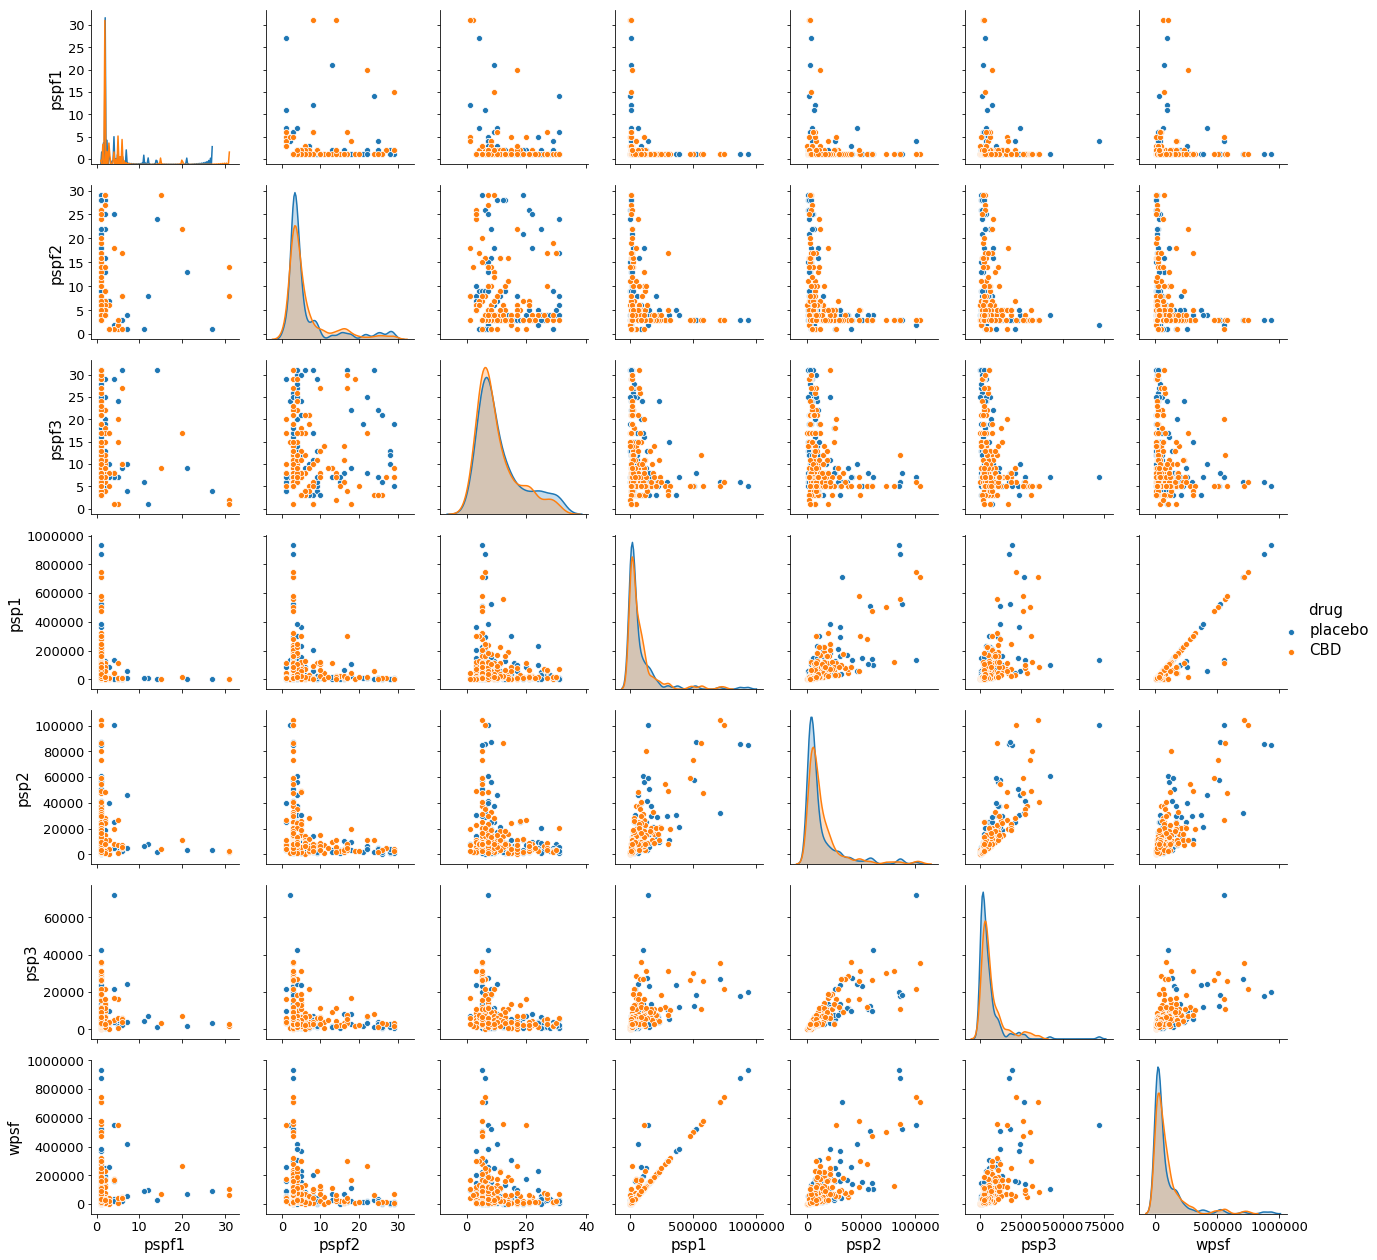

In [7]:
#Colunas numericas
numeric_cols = df_parkinson.columns[1:-3].values

#Pairplot
pairplot(df_parkinson,numeric_cols,'drug')

Dados que as distribuições aparentam ser assimétricas, iremos aplicar a box cox com o intuito de normalizar os dados.

In [8]:
#Normalização via boxcox
for col in numeric_cols:
    df_parkinson.loc[:,col],_ = boxcox(df_parkinson.loc[:,col])
    
#Normalizacao dos dados - media 0 e desvio padrao 1
# df_parkinson.loc[:,numeric_cols] = StandardScaler().fit_transform(df_parkinson.loc[:,numeric_cols])

#Normalizacao dos dados - min 0 e max 1
df_parkinson.loc[:,numeric_cols] = MinMaxScaler().fit_transform(df_parkinson.loc[:,numeric_cols])

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


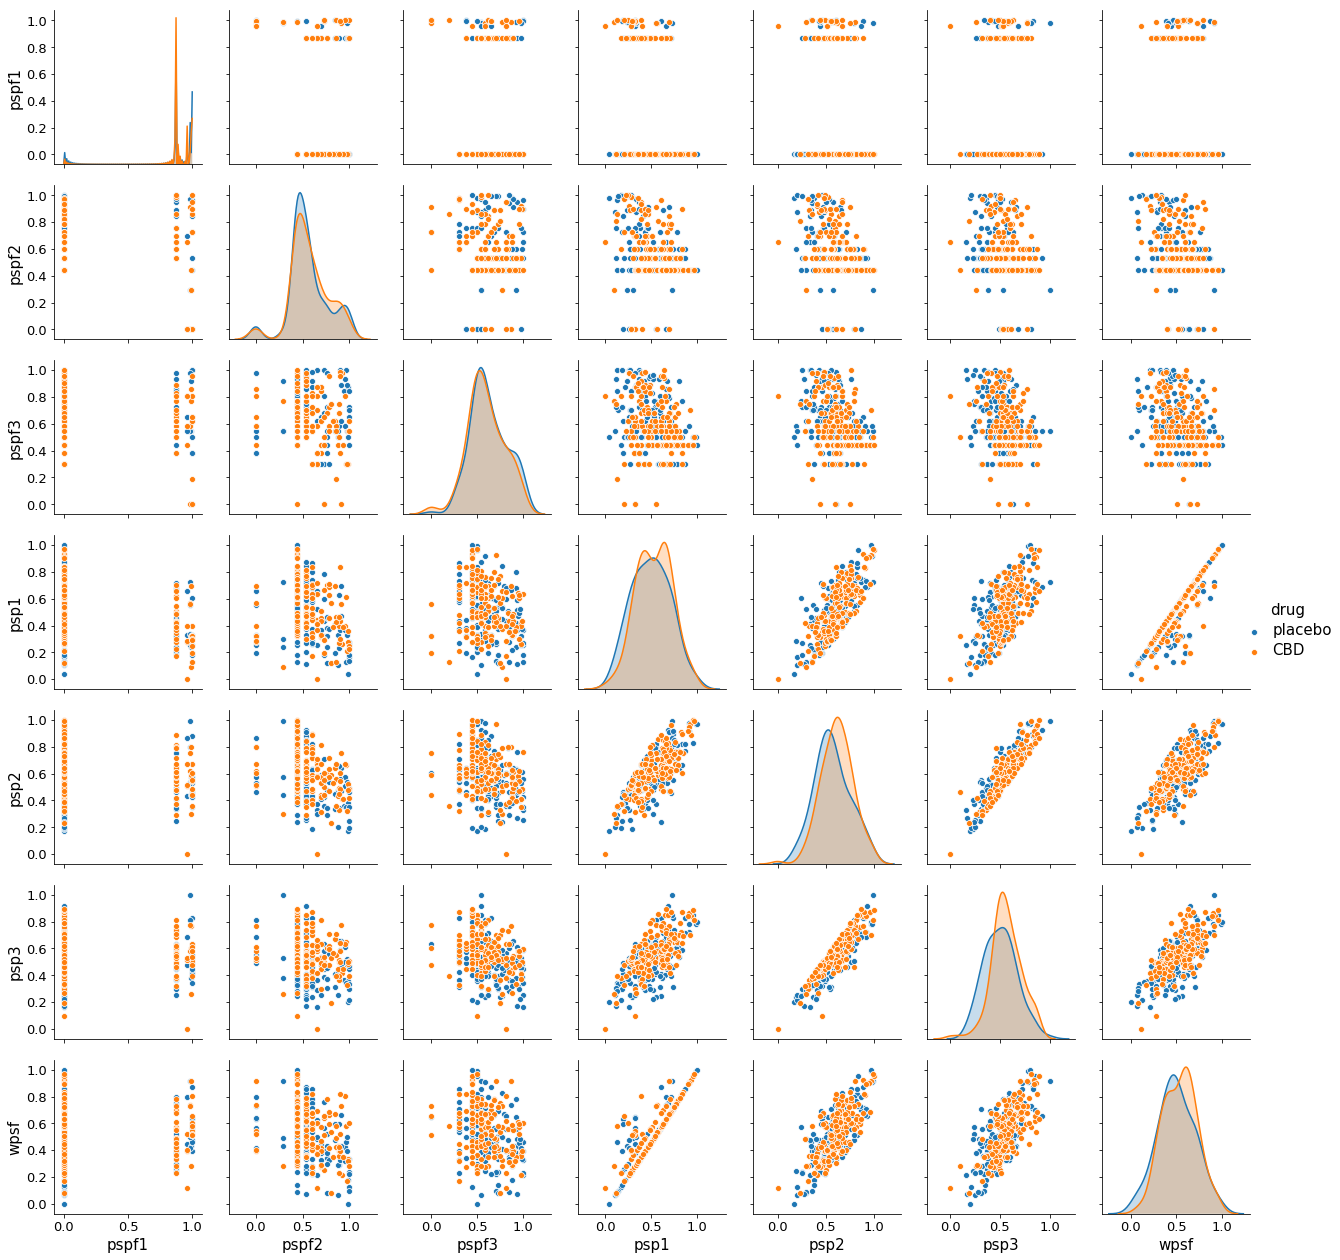

In [9]:
#Pairplot
pairplot(df_parkinson,numeric_cols,'drug')

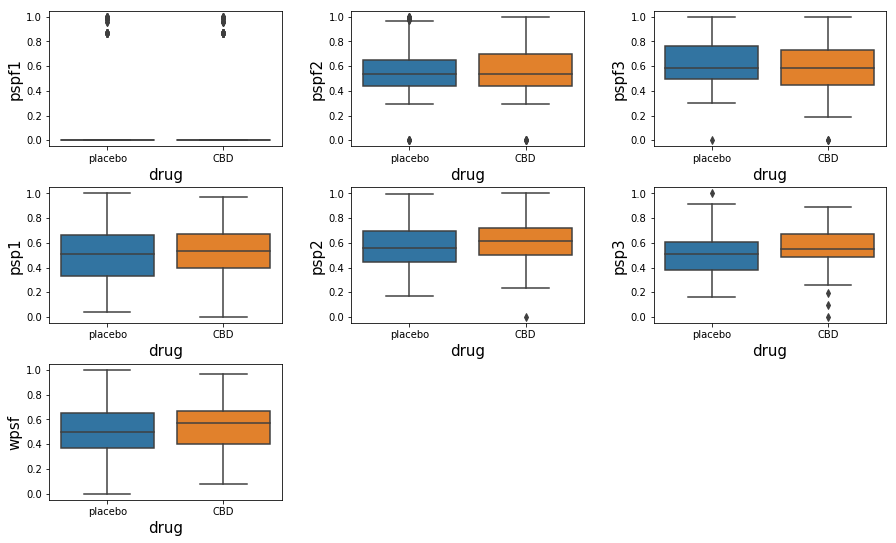

In [10]:
#Boxplot divido por droga
boxplot(df_parkinson,numeric_cols,'drug')

Pelo boxplot aparentemente não há nenhuma diferença significativa nos grupos, mas há outliers.

E segundo o pairplot existe algumas relações lineares como é o caso dos psp's e pse com outras variáveis.

Além disso, em todos os atributos os espaços aparentam estar com as clases sobrepostas. Usar um classificador nesses dados provavelmente não produzirá bons resultados.

In [11]:
#Divide dataset por droga
df_drug1 = df_parkinson[df_parkinson['drug'] == 'placebo'].copy()
df_drug2 = df_parkinson[df_parkinson['drug'] == 'CBD'].copy()

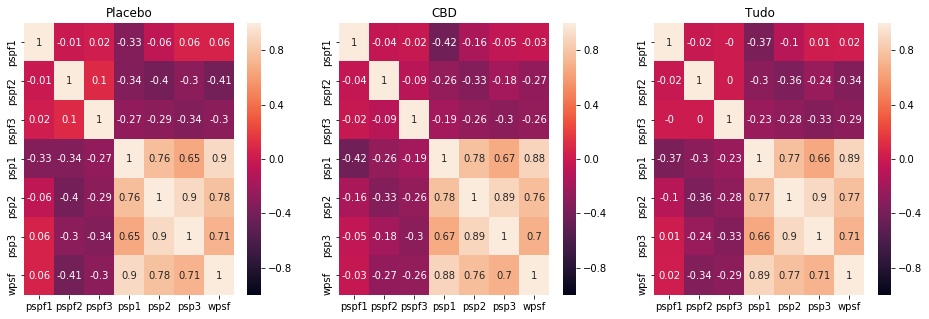

In [12]:
#Heatmap das correlações
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(131,title='Placebo')
sns.heatmap(round(df_drug1.loc[:,numeric_cols].corr(),2),vmin=-1,vmax=1,annot=True,ax=ax)
ax = fig.add_subplot(132,title='CBD')
sns.heatmap(round(df_drug2.loc[:,numeric_cols].corr(),2),vmin=-1,vmax=1,annot=True,ax=ax)
ax = fig.add_subplot(133,title='Tudo')
sns.heatmap(round(df_parkinson.loc[:,numeric_cols].corr(),2),vmin=-1,vmax=1,annot=True,ax=ax)
plt.show()

Olhando o heatmap temos que as principais correlações são:
- psp's entre si (Positiva).
- wspf com todos os psp's (Positiva).
- wpsf com pse (Negativa).
- psp1 com pse (Negativa)

In [13]:
#ANOVA entre os atributos
_, pvalue = f_oneway(df_drug1.loc[:,numeric_cols],df_drug2.loc[:,numeric_cols])
dict(zip(numeric_cols,pvalue))

{'pspf1': 0.5404413304453314,
 'pspf2': 0.6868012030047819,
 'pspf3': 0.16244488792022468,
 'psp1': 0.13919111367613957,
 'psp2': 0.01902159427296176,
 'psp3': 0.0006772443524067225,
 'wpsf': 0.10062331175859199}

Segundo o anova temos difenças significativas em psp2 e psp3.

## 2.2 Análise dos dados dividos por tipo de droga porém sumarizados ao longo do tempo

Iremos realizar as análises nos mesmos grupos propostos anteriomente, contudo, faremos uma sumarização dos dados temporais para cada pessoa no seu respectivo grupo.

In [14]:
#Média de cada atributo por droga e pessoa - sumarização dos dados temporais
df_summary_parkinson = df_parkinson.drop(columns='evaluate').groupby(['drug','name']).agg(np.mean).reset_index()

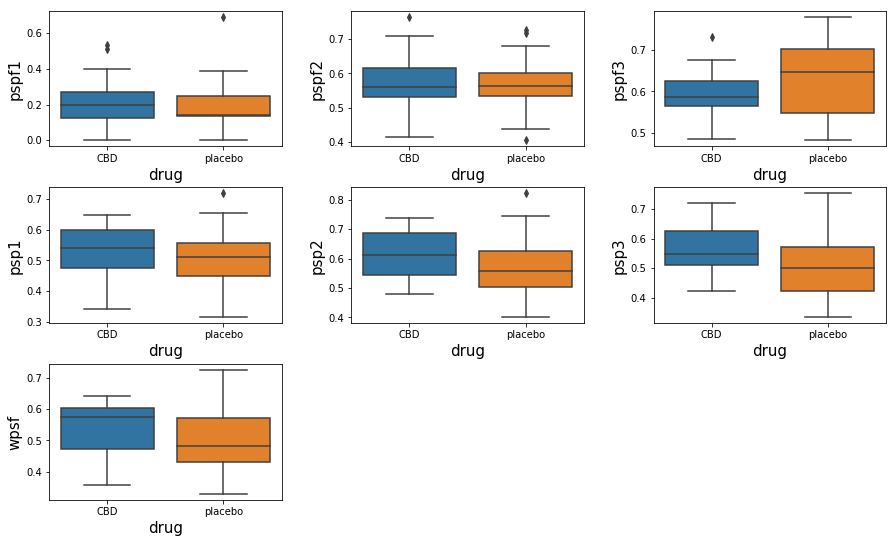

In [15]:
#Boxplot divido por grupo para as medias dos atributos de cada pessoa
boxplot(df_summary_parkinson,numeric_cols,'drug')

In [16]:
#Divindo dataset por tipo de droga
df_drug1 = df_summary_parkinson[df_summary_parkinson['drug'] == 'placebo'].copy()
df_drug2 = df_summary_parkinson[df_summary_parkinson['drug'] == 'CBD'].copy()

#ANOVA entre os atributos
_, pvalue = f_oneway(df_drug1.loc[:,numeric_cols],df_drug2.loc[:,numeric_cols])
dict(zip(numeric_cols,pvalue))

{'pspf1': 0.5580242045761195,
 'pspf2': 0.7069946412241368,
 'pspf3': 0.1723016203044765,
 'psp1': 0.24199222087895447,
 'psp2': 0.11053323679907388,
 'psp3': 0.037854850468851994,
 'wpsf': 0.22057298416249774}

Realizando a média para as séries temporais temos que os boxplot's tendem a ficar mais 'shifitados'. Contudo, isso possívelmente ocorreu por causa da sumarização dos outliers, que tenderam a sumir por causa da média.

Segundo o ANOVA temos diferença apenas no atributo psp3.

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


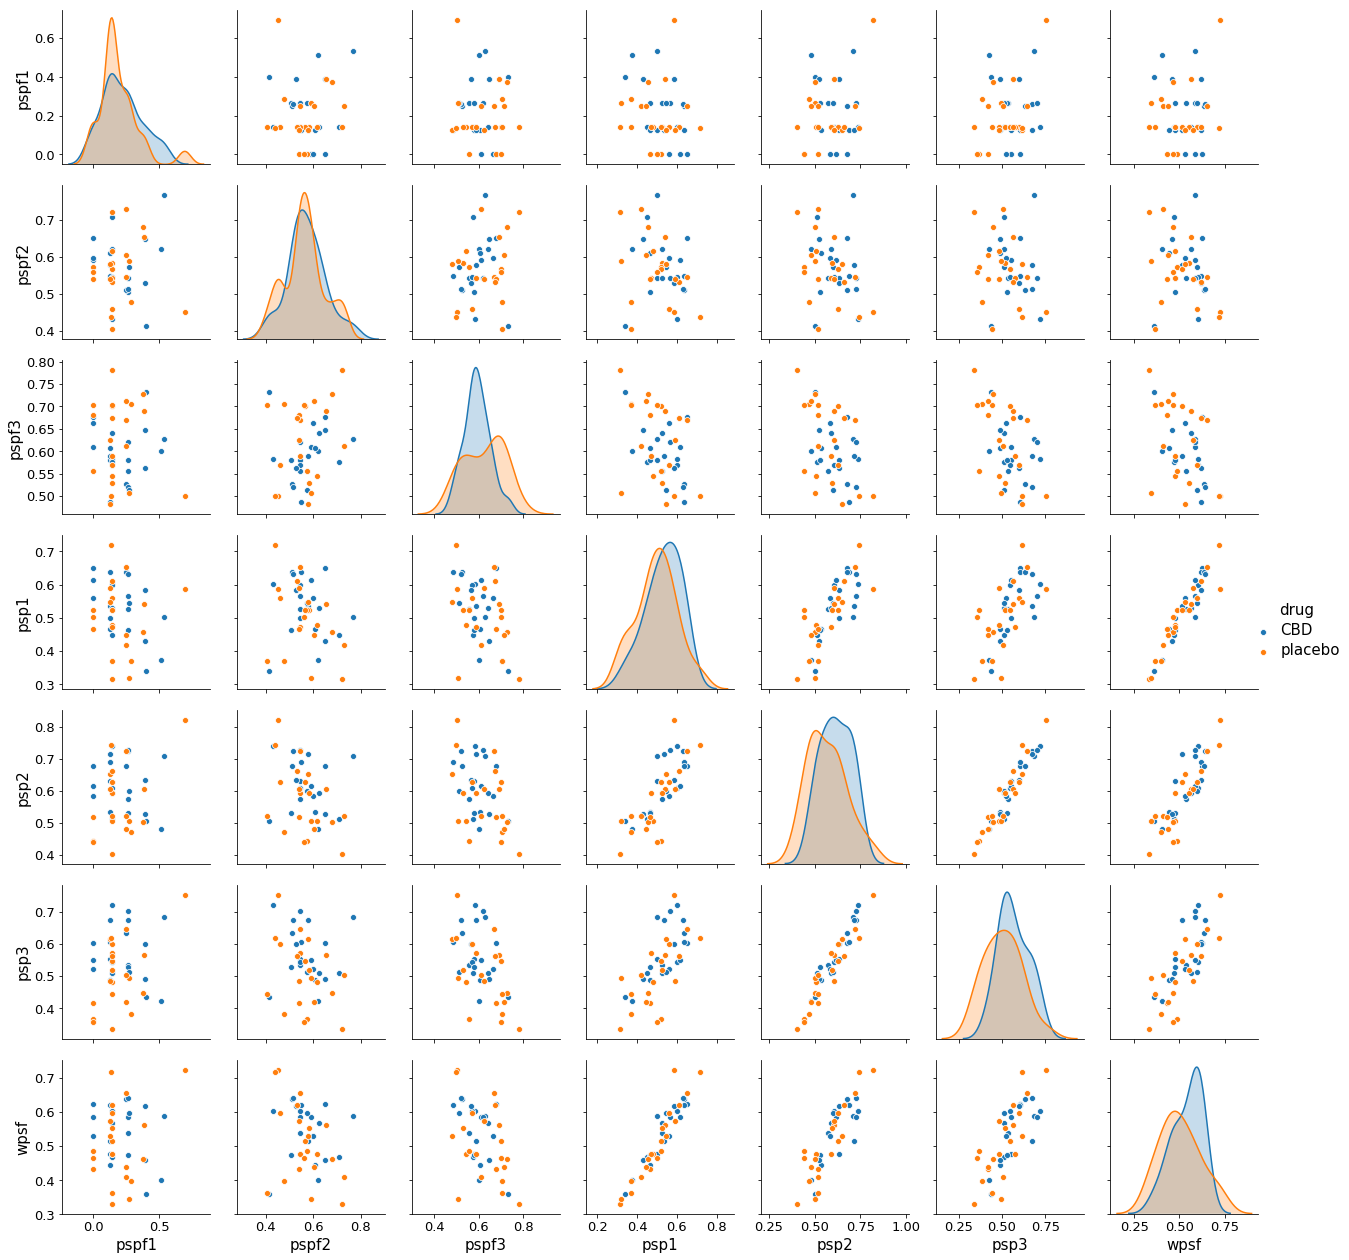

In [17]:
#Pairplot
pairplot(df_summary_parkinson,numeric_cols,'drug')

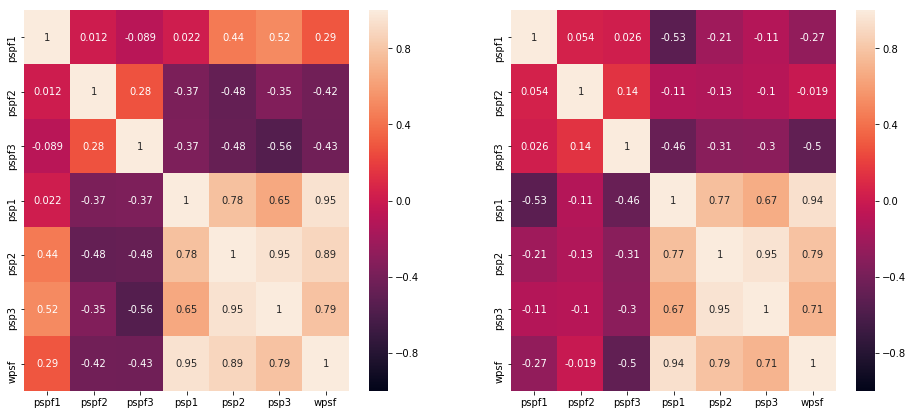

In [18]:
#Heatmap
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(121)
ax = sns.heatmap(df_drug1.loc[:,numeric_cols].corr(),vmin=-1,vmax=1,annot=True,ax=ax)
ax = fig.add_subplot(122)
sns.heatmap(df_drug2.loc[:,numeric_cols].corr(),vmin=-1,vmax=1,annot=True,ax=ax)
plt.show()

É interessante notar que a sumarização deixou mais visível que as classes estão distribuídas de maneira 'aleatória' para cada atributo no espaço. 

As correlações ficaram praticamente as mesmas com excecão de uma adição:
- pse com pspf1 (Positiva).

In [19]:
#Desvio padrão de cada atributo por droga e pessoa - sumarização dos dados temporais
df_summary_parkinson = df_parkinson.drop(columns=['measure','evaluate']).groupby(['drug','name']).agg(np.std).reset_index()

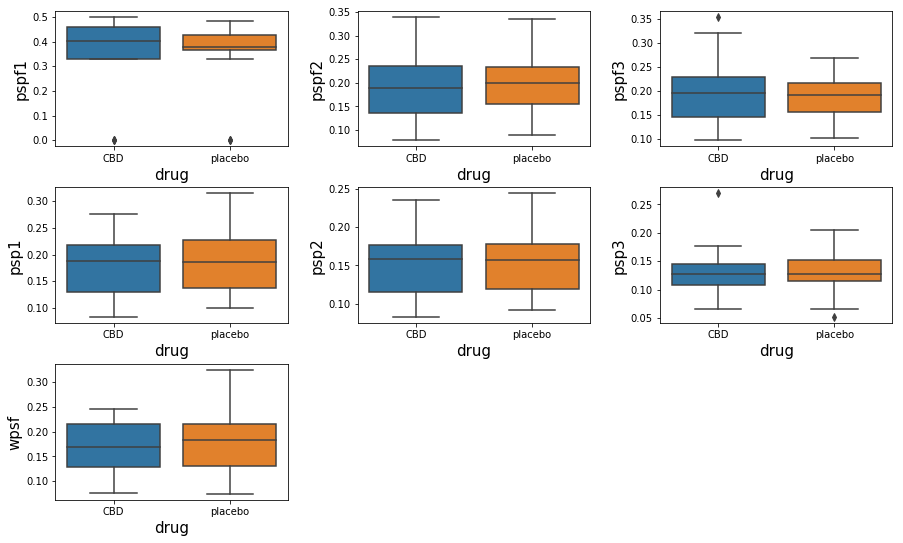

In [20]:
#Boxplot divido por grupo para o desvio padrão dos atributos de cada pessoa
boxplot(df_summary_parkinson,numeric_cols,'drug')

In [21]:
#Divindo dataset por tipo de droga
df_drug1 = df_summary_parkinson[df_summary_parkinson['drug'] == 'placebo'].copy()
df_drug2 = df_summary_parkinson[df_summary_parkinson['drug'] == 'CBD'].copy()

#ANOVA entre os atributos
_, pvalue = f_oneway(df_drug1.loc[:,numeric_cols],df_drug2.loc[:,numeric_cols])
dict(zip(numeric_cols,pvalue))

{'pspf1': 0.7630092901979206,
 'pspf2': 0.7546846993021844,
 'pspf3': 0.47860876059071955,
 'psp1': 0.5978319515078616,
 'psp2': 0.6419254337951064,
 'psp3': 0.9683054902962608,
 'wpsf': 0.5667751304670325}

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


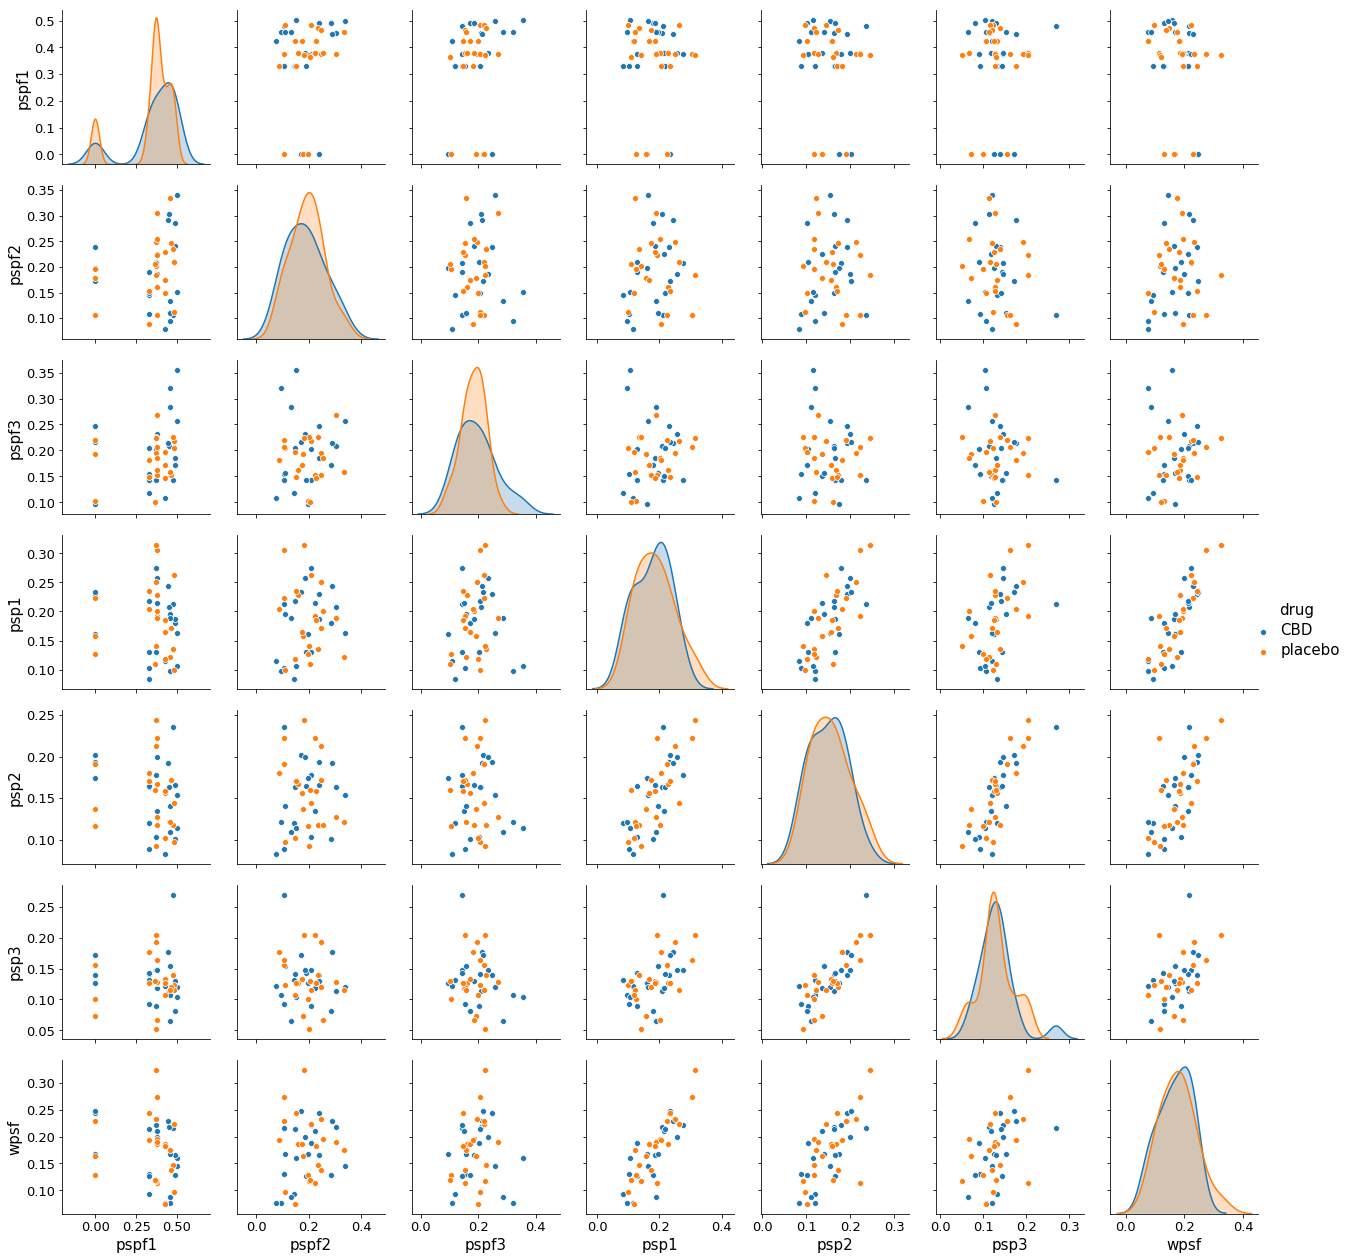

In [22]:
#Pairplot
pairplot(df_summary_parkinson,numeric_cols,'drug')

Segundo o ANOVA não há diferenças significativas apenas em pse. Nos chama a atenção novamente que os boxplot's estão mais 'shifitados' assim como os espaços das variáveis parecem ser mais divisíveis.

Possívelmente uma combinação da média e desvio padrão dos atributos pode ser útil.

## 2.3 Análise dos dados divididos por tipo de droga e com métricas resumidas por amostra

Iremos utilizar o mesmo agrupamento anterior mas agora com as métricas resumidas ao longo das amostras com o mesmo objetivo de avaliar diferenças significativas.

In [23]:
#Copia
df_summary_parkinson = df_parkinson.copy()

#Excluindo colunas desnecessarias
df_summary_parkinson.drop(columns=['measure','evaluate','pse','pspf1','pspf2','pspf3','psp1','psp2','psp3'],inplace=True)

#Calculando resumos por amostras
df_summary_parkinson['pspf_mean'] = df_parkinson.apply(lambda x: x[['pspf1','pspf2','pspf3']].mean(),axis=1)
df_summary_parkinson['pspf_std'] = df_parkinson.apply(lambda x: x[['pspf1','pspf2','pspf3']].std(),axis=1)
df_summary_parkinson['psp_mean'] = df_parkinson.apply(lambda x: x[['psp1','psp2','psp3']].mean(),axis=1)
df_summary_parkinson['psp_std'] = df_parkinson.apply(lambda x: x[['psp1','psp2','psp3']].std(),axis=1)

In [24]:
#Colunas numericas
numeric_cols = df_summary_parkinson.select_dtypes('float').columns.values

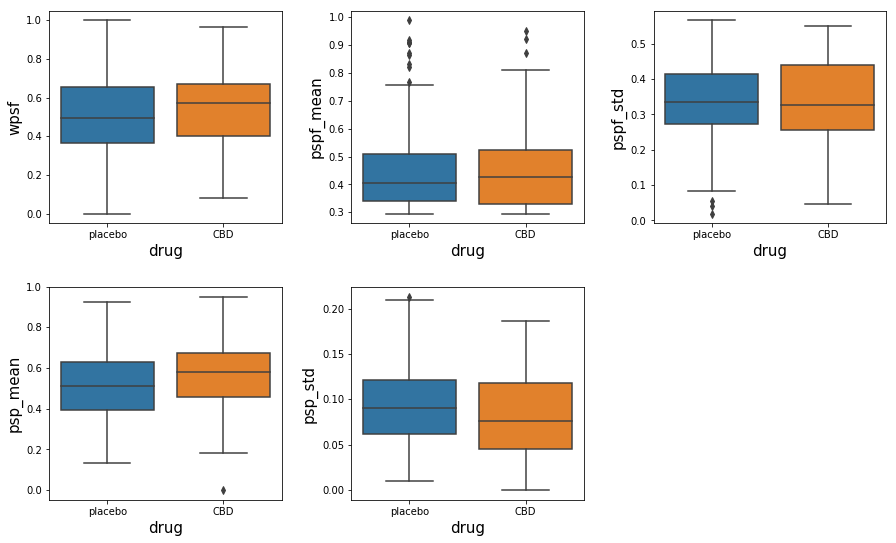

{'wpsf': 0.10062331175858562,
 'pspf_mean': 0.9269976801687334,
 'pspf_std': 0.7246847730802282,
 'psp_mean': 0.011289726283135125,
 'psp_std': 0.04545473655993233}

In [25]:
#Boxplot
boxplot(df_summary_parkinson,numeric_cols,'drug')

#Divindo dataset por tipo de droga
df_drug1 = df_summary_parkinson[df_summary_parkinson['drug'] == 'placebo'].copy()
df_drug2 = df_summary_parkinson[df_summary_parkinson['drug'] == 'CBD'].copy()

#ANOVA entre os atributos
_, pvalue = f_oneway(df_drug1.loc[:,numeric_cols],df_drug2.loc[:,numeric_cols])
dict(zip(numeric_cols,pvalue))

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


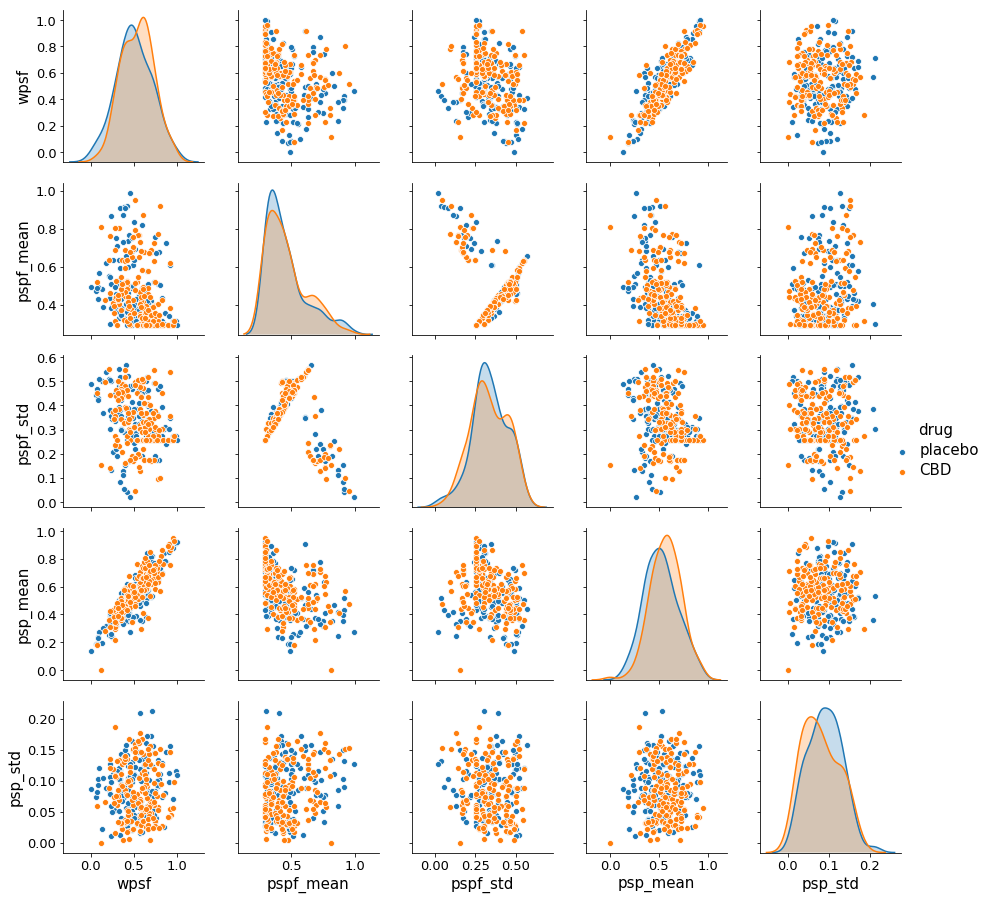

In [26]:
#Pairplot
pairplot(df_summary_parkinson,numeric_cols,'drug')

Como podemos ver a distribuição no espaço ainda é aleatória, contudo, foi possível obter uma signifiância no atributo pse_mean.

## 2.4 Análise dos dados dividos por tipo de droga porém sumarizados ao longo do tempo e por amostra

Iremos adicionar as outras análises o fato de que para cada amostra iremos sumarizar os dados, por exemplo, para uma amostra iremos calcular a média de psp1,psp2 e psp3. Depois disso realizaremos novamente um resumo ao longo do tempo e depois novas análises para os grupos dividos por tipo de droga.

In [27]:
#Copia do dataframe sem as colunas que seram resumidas
df_summary_parkinson = df_parkinson.drop(columns=['evaluate','measure','pspf1','pspf2','pspf3','psp1','psp2','psp3']).copy()

#Resumo das metricas por meio da media
df_summary_parkinson['pspf'] = df_parkinson.apply(lambda x: x[['pspf1','pspf2','pspf3']].mean(),axis=1)
df_summary_parkinson['psp'] = df_parkinson.apply(lambda x: x[['psp1','psp2','psp3']].mean(),axis=1)

#Resumo das metricas ao longo do tempo
df_summary_parkinson = df_summary_parkinson.groupby(['drug','name']).agg(np.mean).reset_index()

#Colunas numericas
numeric_cols = df_summary_parkinson.columns[2:].values

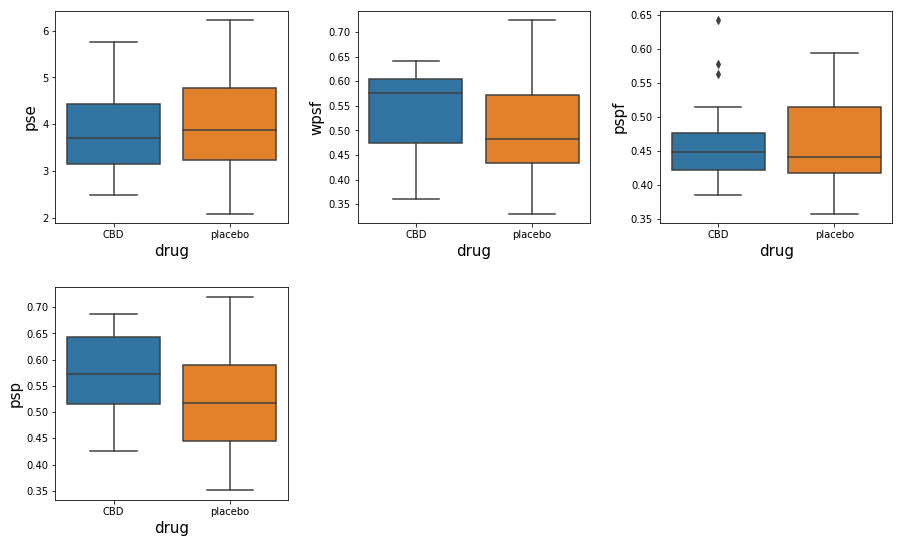

In [28]:
#Boxplot
boxplot(df_summary_parkinson,numeric_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


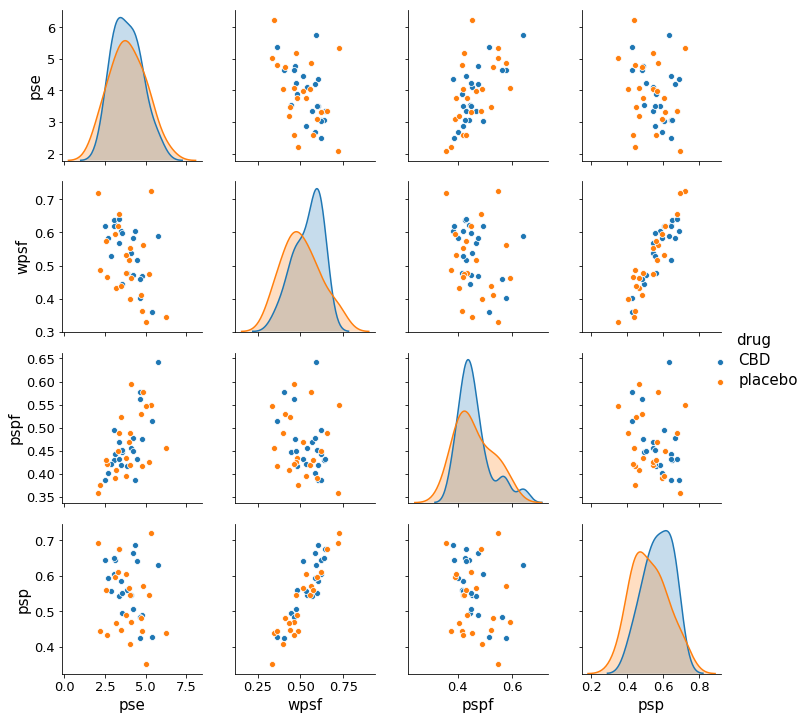

In [29]:
#Pairplot
pairplot(df_summary_parkinson,numeric_cols,'drug')

Praticamente as mesmas conclusões obtidas pela seção anterior.

## 2.5 Análise dos dados divididos por tipo de avaliação

Iremos agora dividir os dados por meio da avaliação com o objetivo de verificar se dependendo dela os resultados da droga são diferentes.

In [30]:
#Colunas numericas
numeric_cols = df_parkinson.columns[2:-2].values

#Divindo dados
df_evaluate1 = df_parkinson[df_parkinson['evaluate'] == 1]
df_evaluate2 = df_parkinson[df_parkinson['evaluate'] == 2]

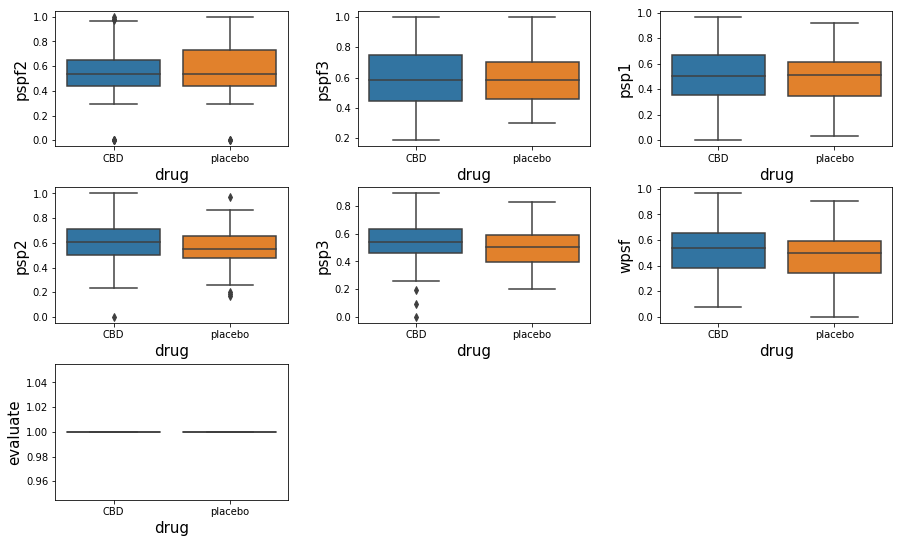

In [31]:
#Boxplot
boxplot(df_evaluate1,numeric_cols,'drug')

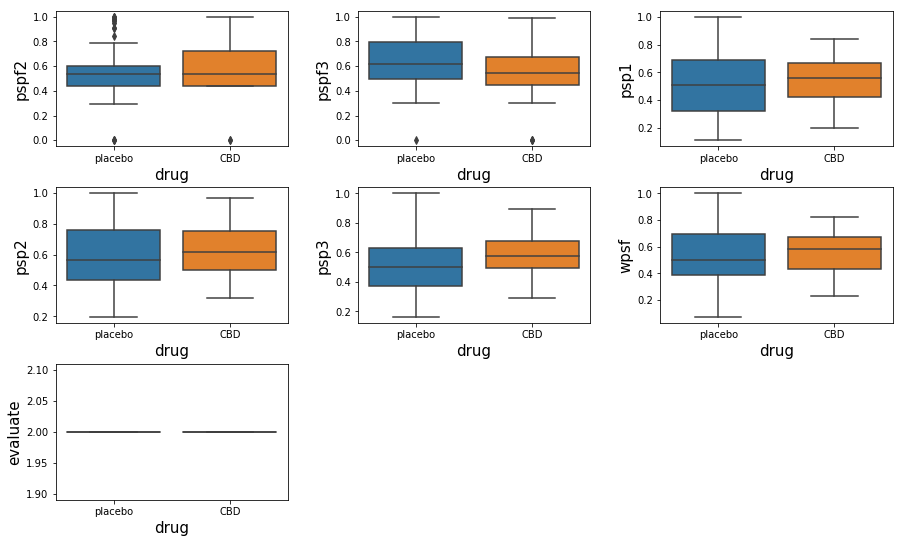

In [32]:
#Boxplot
boxplot(df_evaluate2,numeric_cols,'drug')

In [33]:
#ANOVA entre os atributos
_, pvalue = f_oneway(df_evaluate1.loc[df_evaluate1['drug'] == 'placebo',numeric_cols],df_evaluate1.loc[df_evaluate1['drug'] == 'CBD',numeric_cols])
dict(zip(numeric_cols,pvalue))

{'pspf2': 0.5884907089137863,
 'pspf3': 0.5417618102424482,
 'psp1': 0.2632045069467537,
 'psp2': 0.05208315698557737,
 'psp3': 0.027923249967055953,
 'wpsf': 0.17251787743408947,
 'evaluate': 1.2016083508390524e-24}

In [34]:
#ANOVA entre os atributos
_, pvalue = f_oneway(df_evaluate2.loc[df_evaluate2['drug'] == 'placebo',numeric_cols],df_evaluate2.loc[df_evaluate2['drug'] == 'CBD',numeric_cols])
dict(zip(numeric_cols,pvalue))

{'pspf2': 0.24323779980238427,
 'pspf3': 0.013777748190479167,
 'psp1': 0.29205802364459366,
 'psp2': 0.12192398279347909,
 'psp3': 0.005178527362403003,
 'wpsf': 0.25443517585957204,
 'evaluate': nan}

É interessante notar que para o atributo psp3 as interpreções são diferentes dependendo da avaliação. Além disso, foi interessante constatar que os p-valores diferentes de uma avaliação para outra. 

Possívelmente essas diferenças ocorrem porque após o primeiro teste as pessoas já estão mais acostumadas.

## 2.6 Análise dos dados divididos por tipo de medida

Iremos realizar análises estatísticas nos dados separados por medida no intuito de averiguar se para diferentes instâncias de tempo temos diferenças significativas.

### 2.6.1 Boxplot's

In [35]:
#Dividindo dataset por medida
df_measureB = df_parkinson[df_parkinson['measure'] == 'B'].drop(columns=['measure','evaluate'])
df_measureP = df_parkinson[df_parkinson['measure'] == 'P'].drop(columns=['measure','evaluate'])
df_measureA = df_parkinson[df_parkinson['measure'] == 'A'].drop(columns=['measure','evaluate'])
df_measureS1 = df_parkinson[df_parkinson['measure'] == 'S1'].drop(columns=['measure','evaluate'])
df_measureS2 = df_parkinson[df_parkinson['measure'] == 'S2'].drop(columns=['measure','evaluate'])
df_measureF1 = df_parkinson[df_parkinson['measure'] == 'F1'].drop(columns=['measure','evaluate'])
df_measureF2 = df_parkinson[df_parkinson['measure'] == 'F2'].drop(columns=['measure','evaluate'])

#Colunas numericas
numeric_cols = df_measureB.columns.values[:-1]

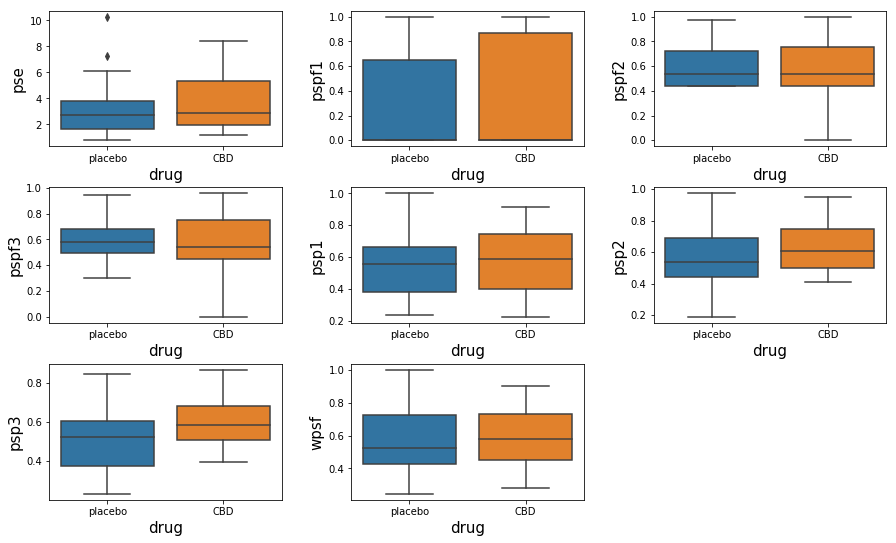

{'pse': 0.4151131363294319, 'pspf1': 0.7071769588502683, 'pspf2': 0.8962541328859701, 'pspf3': 0.39661380905660026, 'psp1': 0.8887344916567044, 'psp2': 0.190967751909271, 'psp3': 0.09219944808363226, 'wpsf': 0.6480224516517821}


In [36]:
#Boxplot - medida B
boxplot(df_measureB,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureB.loc[df_measureB['drug'] == 'placebo',numeric_cols],df_measureB.loc[df_measureB['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

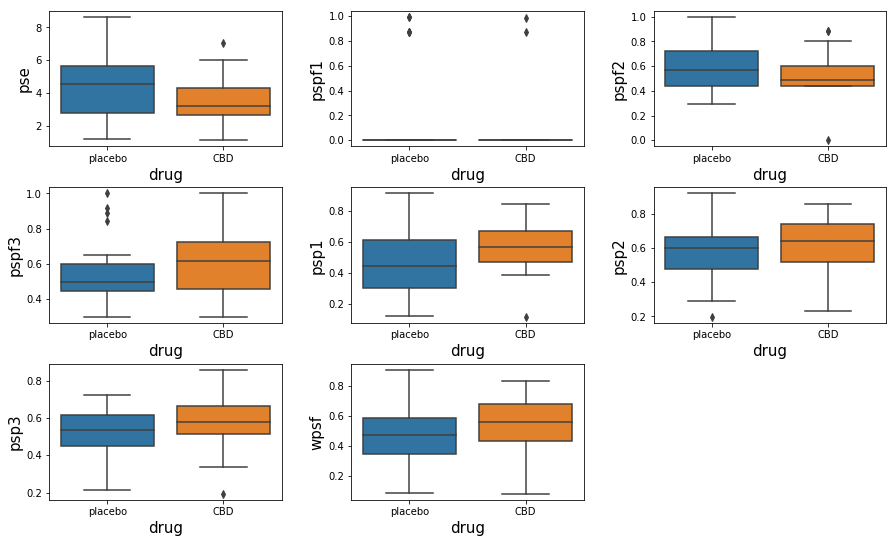

{'pse': 0.15361387526248493, 'pspf1': 0.23039558146893244, 'pspf2': 0.23761266678967952, 'pspf3': 0.1531010483401192, 'psp1': 0.11026414726499101, 'psp2': 0.29611588758119134, 'psp3': 0.21787438842363713, 'wpsf': 0.20340583129688541}


In [37]:
#Boxplot - medida P
boxplot(df_measureP,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureP.loc[df_measureP['drug'] == 'placebo',numeric_cols],df_measureP.loc[df_measureP['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

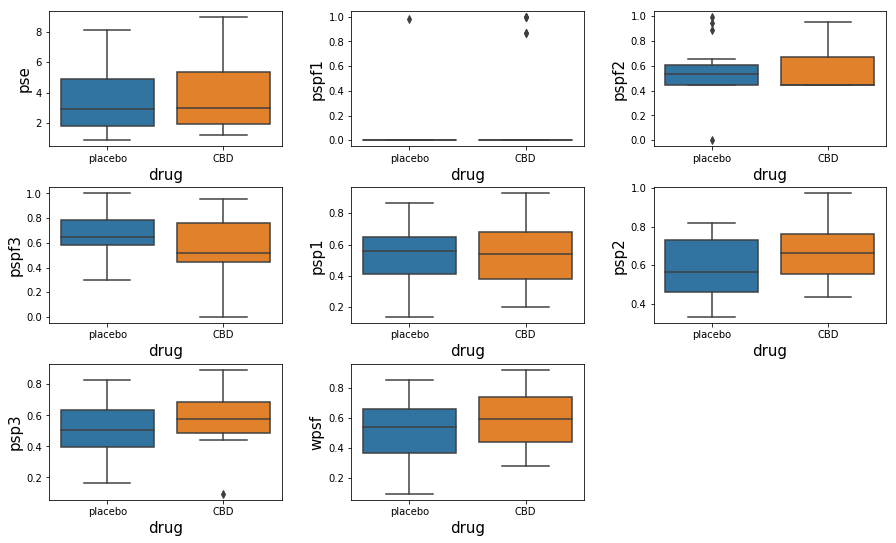

{'pse': 0.6264869234376085, 'pspf1': 0.08806133065294665, 'pspf2': 0.7800007882325803, 'pspf3': 0.26689815813451334, 'psp1': 0.8372741554799404, 'psp2': 0.07070803317345499, 'psp3': 0.20327662300469534, 'wpsf': 0.2582204733386016}


In [38]:
#Boxplot - medida A
boxplot(df_measureA,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureA.loc[df_measureA['drug'] == 'placebo',numeric_cols],df_measureA.loc[df_measureA['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

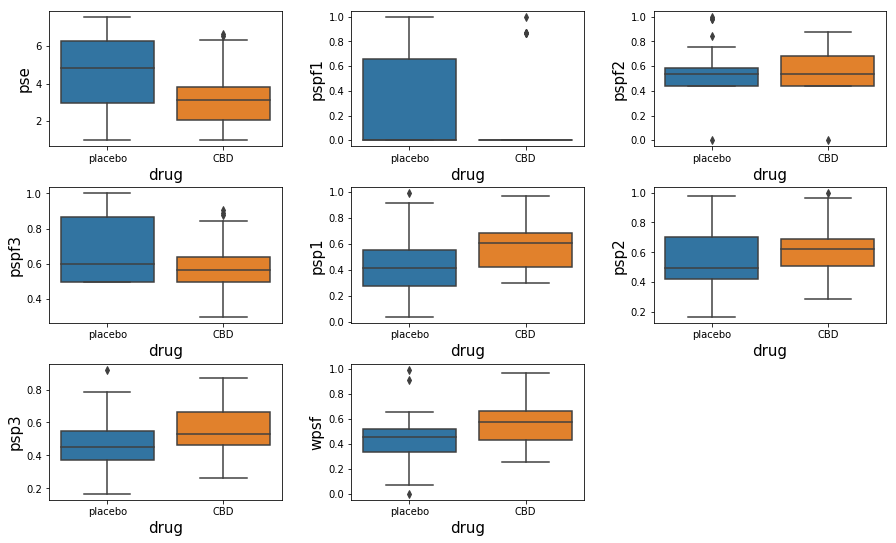

{'pse': 0.020753861337632854, 'pspf1': 0.709548753361994, 'pspf2': 0.8202883455886205, 'pspf3': 0.10208628403934346, 'psp1': 0.06246368373920211, 'psp2': 0.375261122951454, 'psp3': 0.17602244755792595, 'wpsf': 0.09842686873986646}


In [39]:
#Boxplot - medida S1
boxplot(df_measureS1,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureS1.loc[df_measureS1['drug'] == 'placebo',numeric_cols],df_measureS1.loc[df_measureS1['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

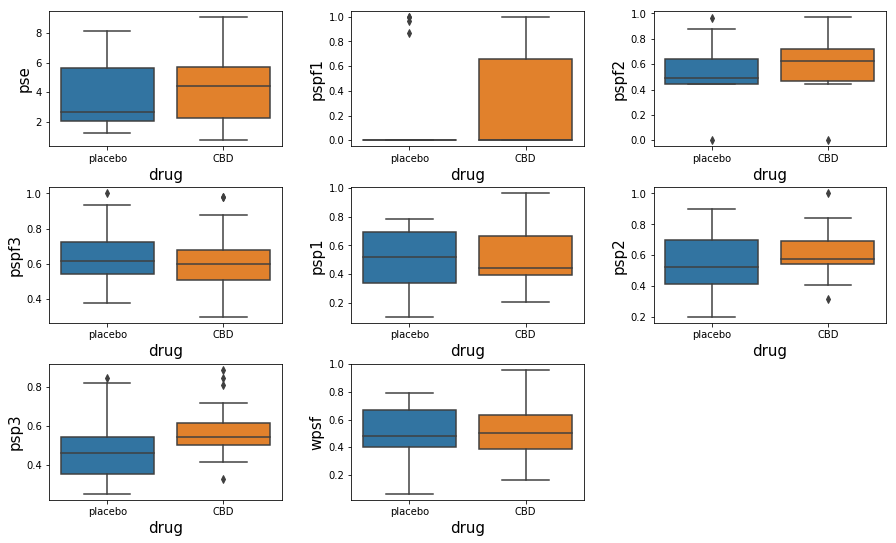

{'pse': 0.3263077033061078, 'pspf1': 0.5433702483599518, 'pspf2': 0.2848066642544357, 'pspf3': 0.4478993953461684, 'psp1': 0.7856027456336614, 'psp2': 0.2156479189040193, 'psp3': 0.04581335929732863, 'wpsf': 0.8400690931504825}


In [40]:
#Boxplot - medida S2
boxplot(df_measureS2,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureS2.loc[df_measureS2['drug'] == 'placebo',numeric_cols],df_measureS2.loc[df_measureS2['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

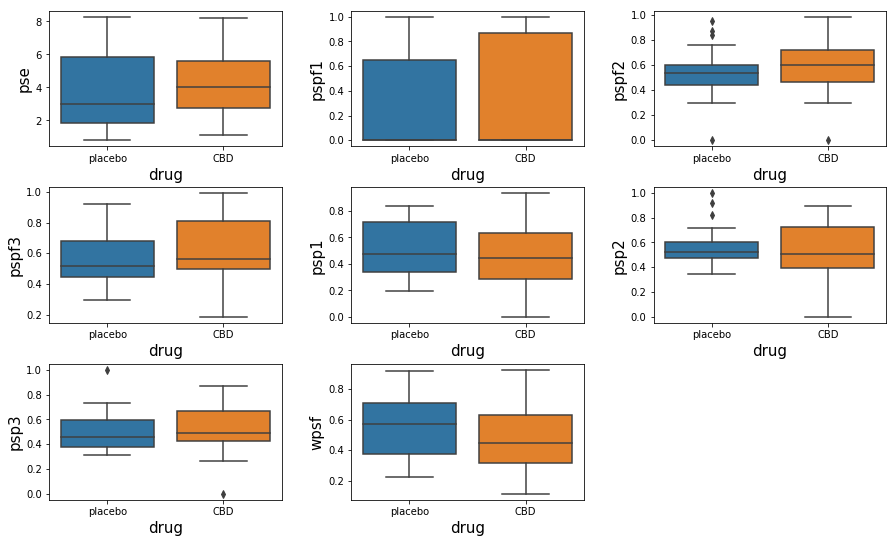

{'pse': 0.35338474667496544, 'pspf1': 0.5668827380480375, 'pspf2': 0.3582161168996033, 'pspf3': 0.3944945381346755, 'psp1': 0.4360179613646733, 'psp2': 0.6792282967074992, 'psp3': 0.723550817182091, 'wpsf': 0.37971989245207205}


In [41]:
#Boxplot - medida F1
boxplot(df_measureF1,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureF1.loc[df_measureF1['drug'] == 'placebo',numeric_cols],df_measureF1.loc[df_measureF1['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

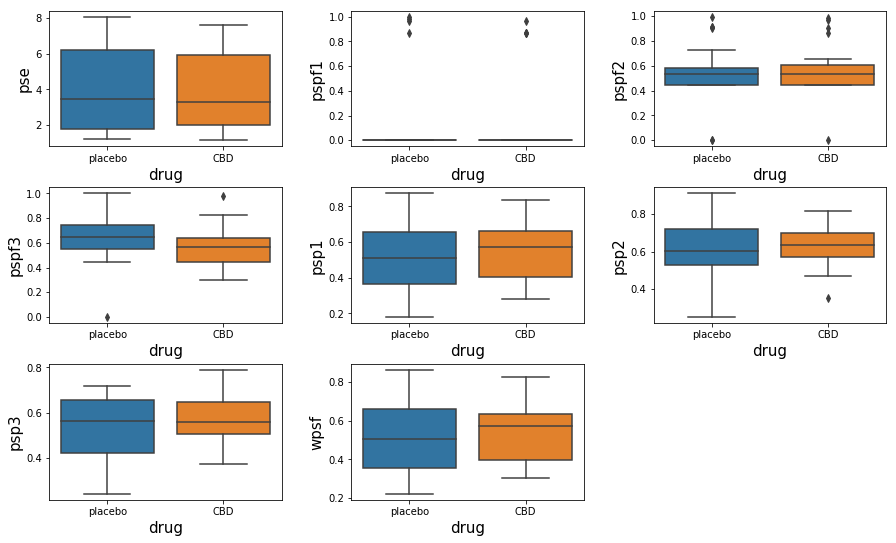

{'pse': 0.6858456124393721, 'pspf1': 0.9216512398048003, 'pspf2': 0.8119265625521752, 'pspf3': 0.11000500922769126, 'psp1': 0.4269244868935773, 'psp2': 0.6594479643626237, 'psp3': 0.2564157501348046, 'wpsf': 0.5999107005824953}


In [42]:
#Boxplot - medida F2
boxplot(df_measureF2,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureF2.loc[df_measureF2['drug'] == 'placebo',numeric_cols],df_measureF2.loc[df_measureF2['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

Note que não há diferenças muito grandes entre os grupos para nenhuma das fases, apesar de em alguns boxplot's termos um shift maior comparado com todos os dados juntos. Nos chama a atenção que dependendo da fase a mediana dos atributos tendem a ter 'shifts' diferentes entre os grupos. Por exemplo, o pspf3 na fase F1 é diferente do da fase F2.

### 2.6.2 Pairplot

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


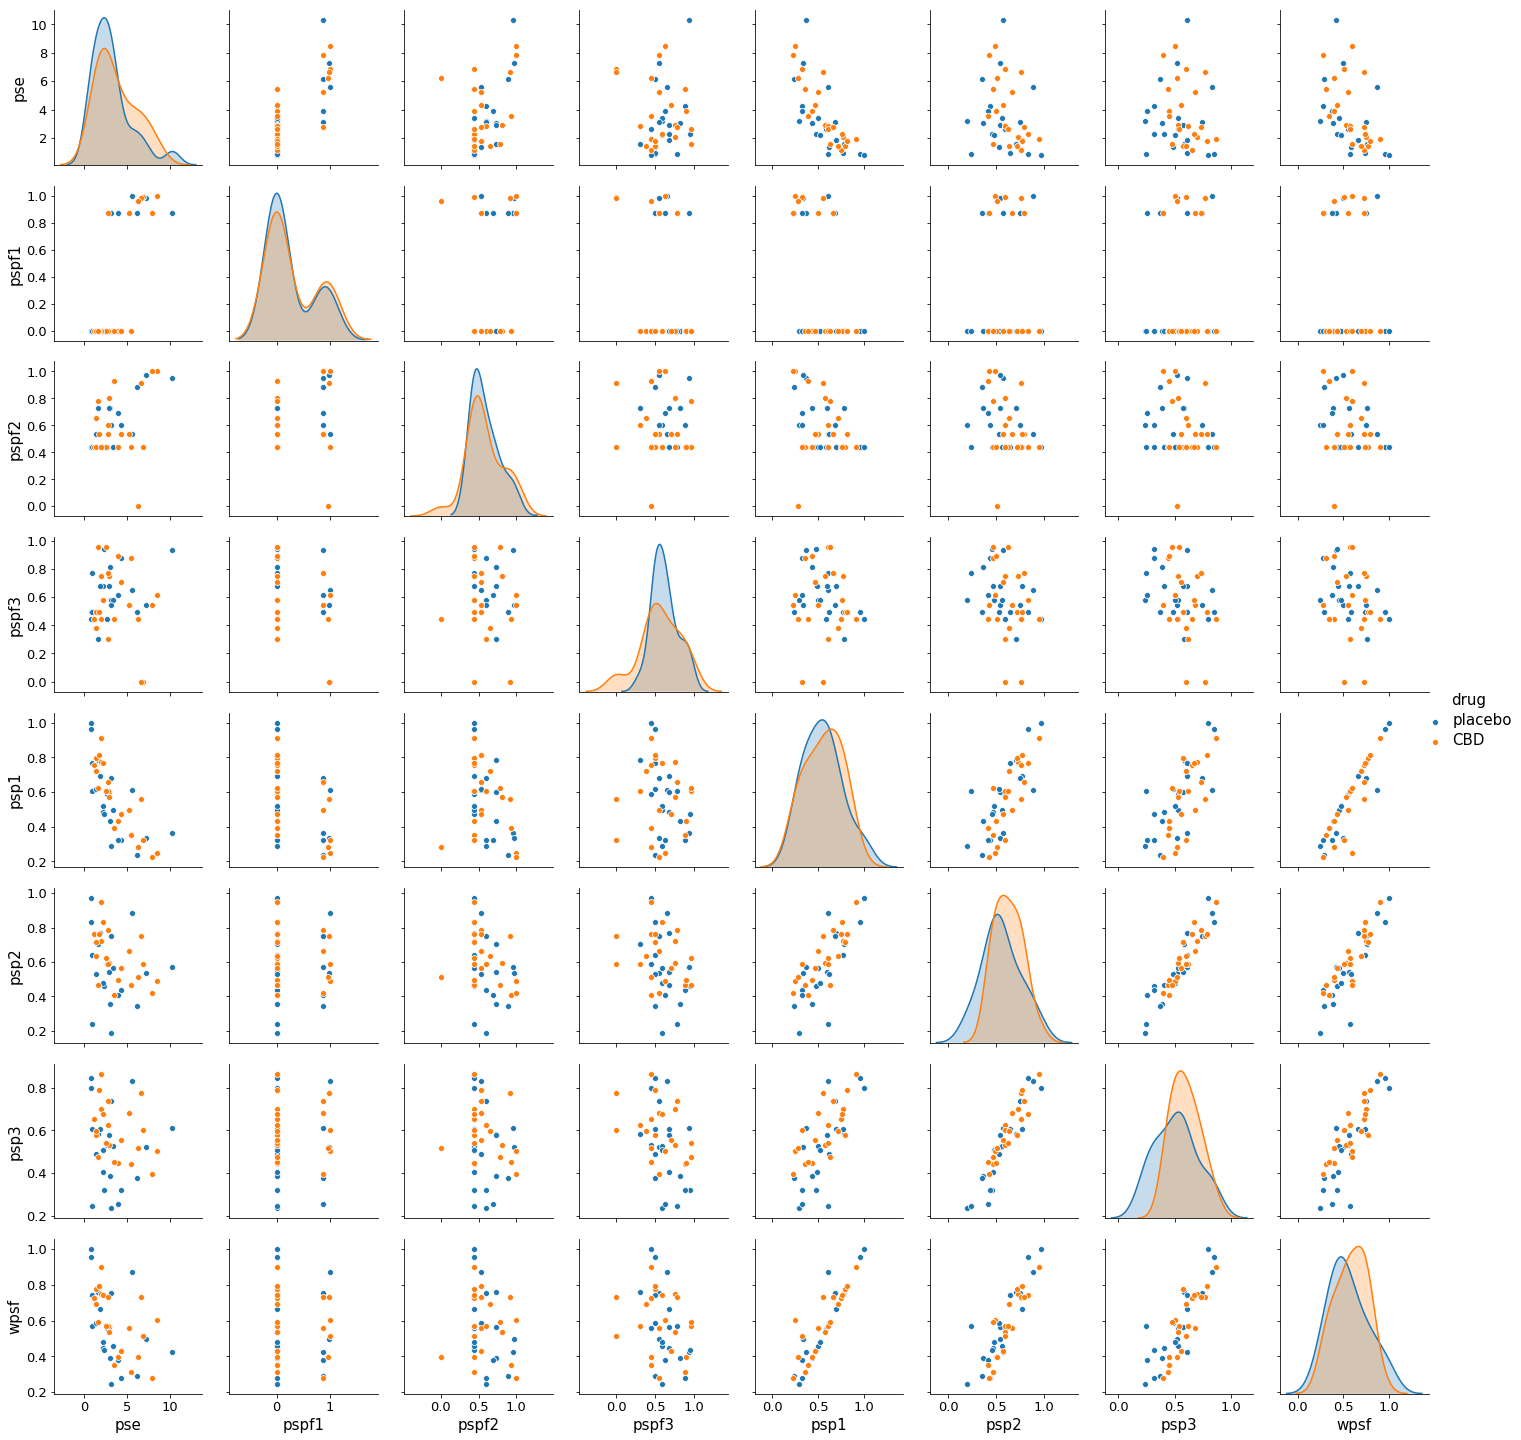

In [43]:
#Pairplot - medida B
pairplot(df_measureB,numeric_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


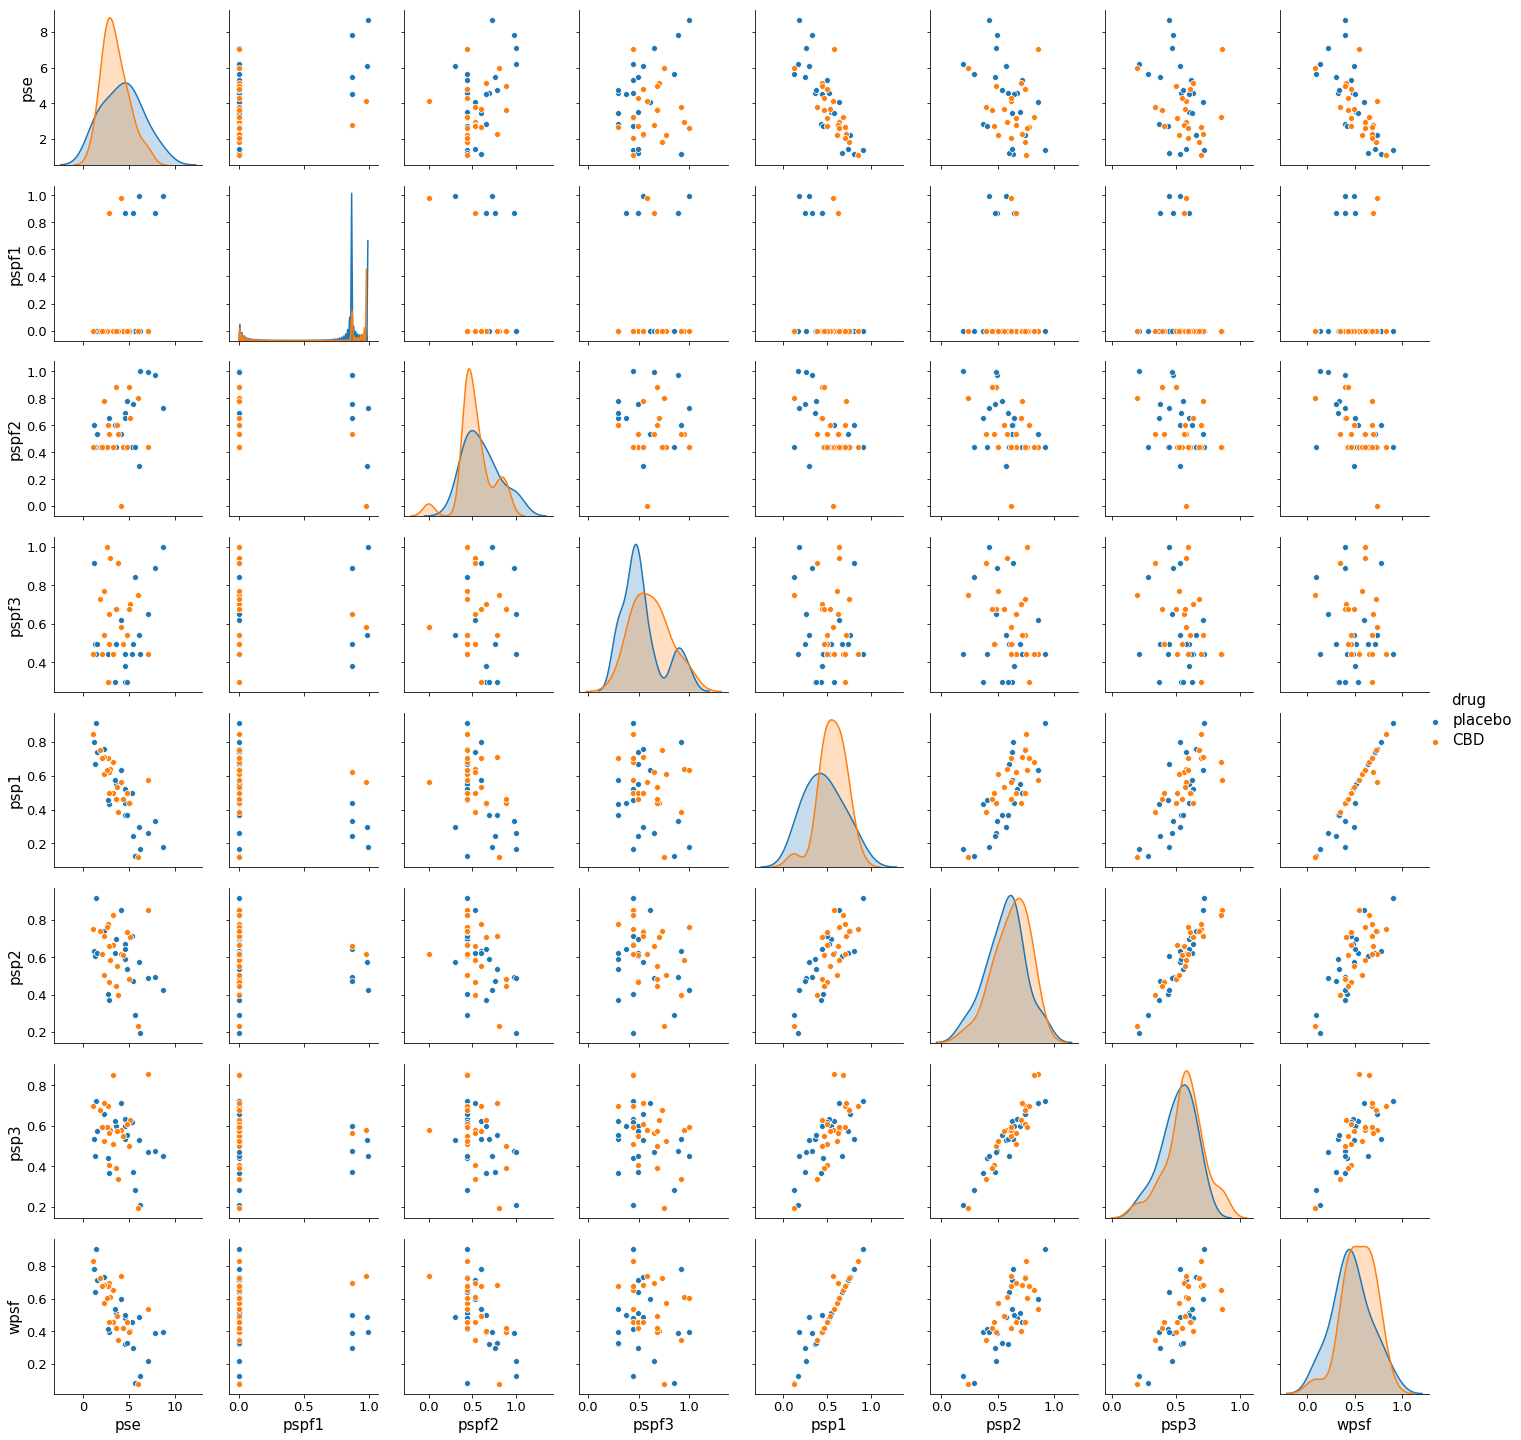

In [44]:
#Pairplot - medida P
pairplot(df_measureP,numeric_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


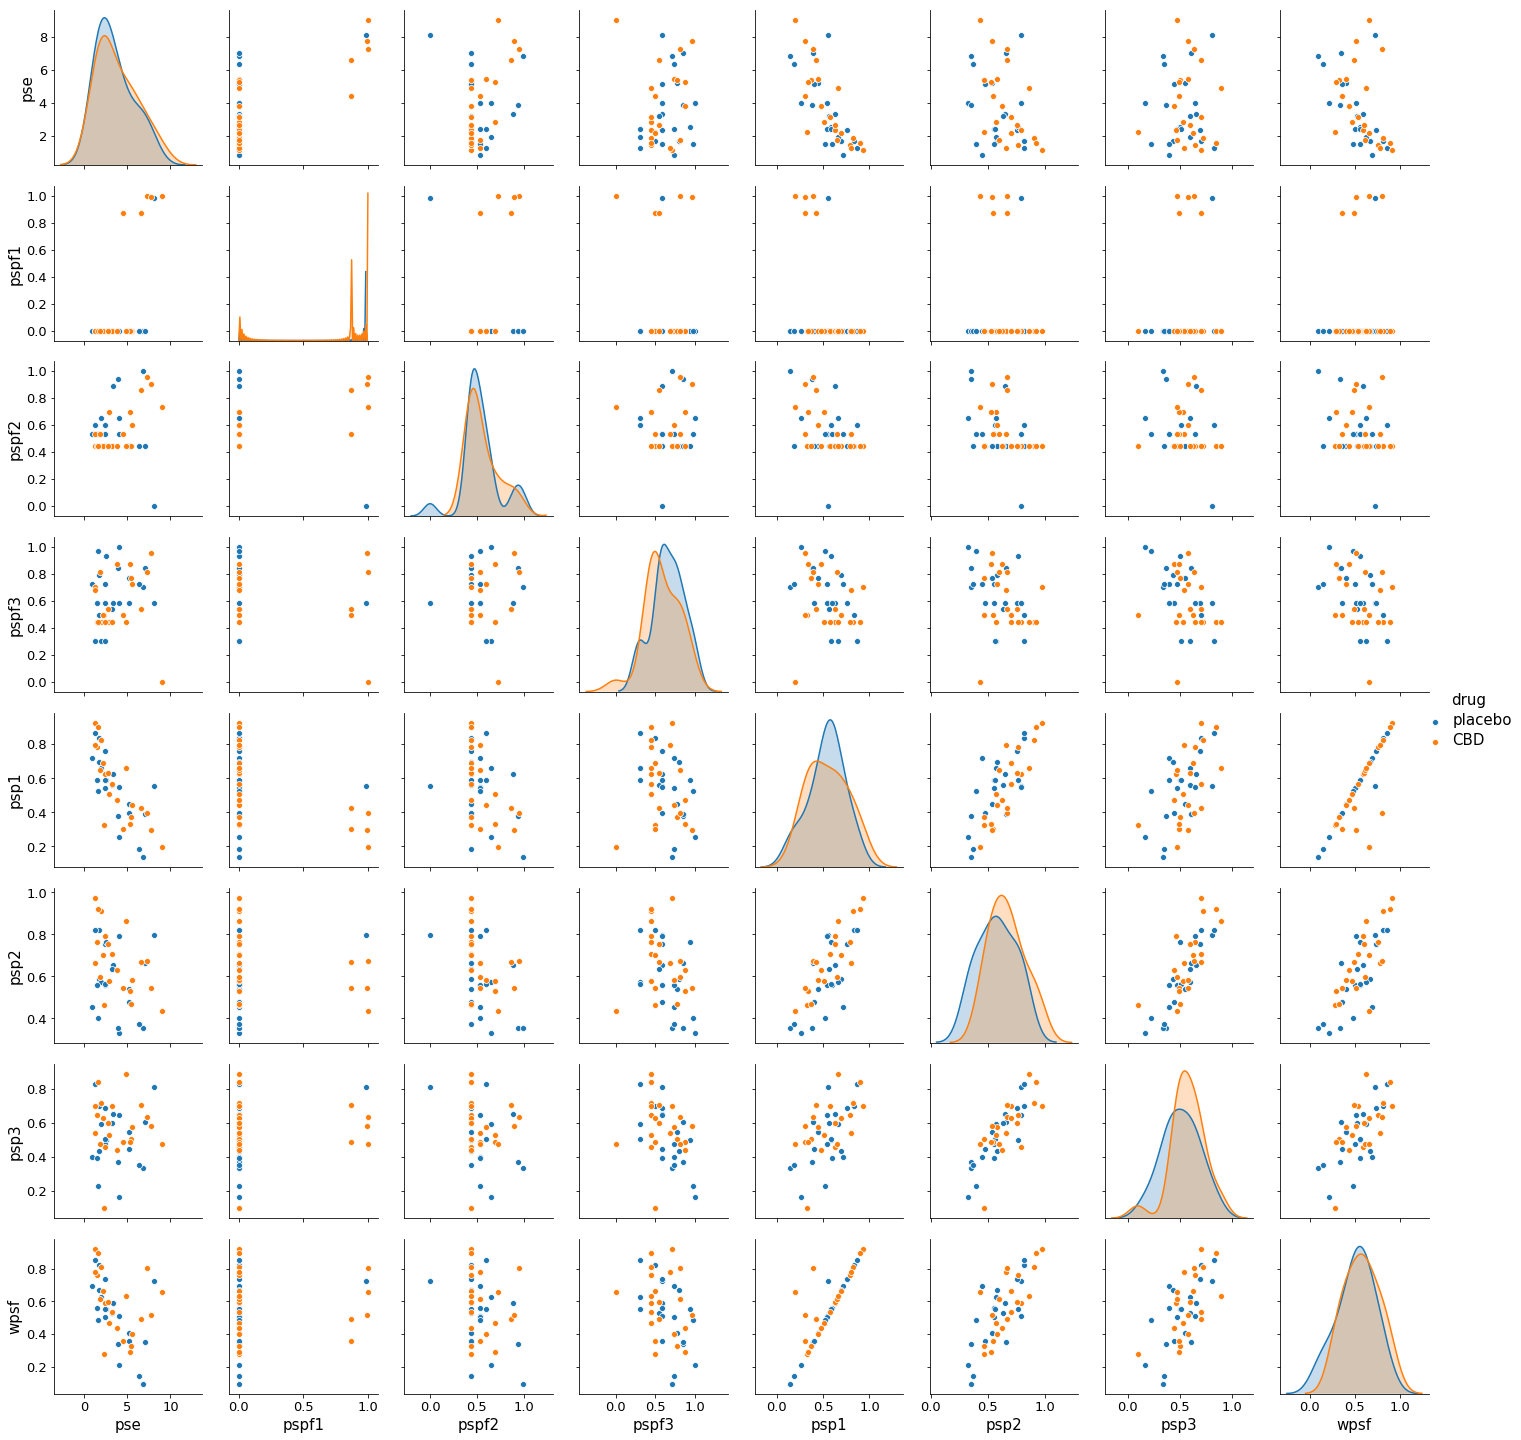

In [45]:
#Pairplot - medida A
pairplot(df_measureA,numeric_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


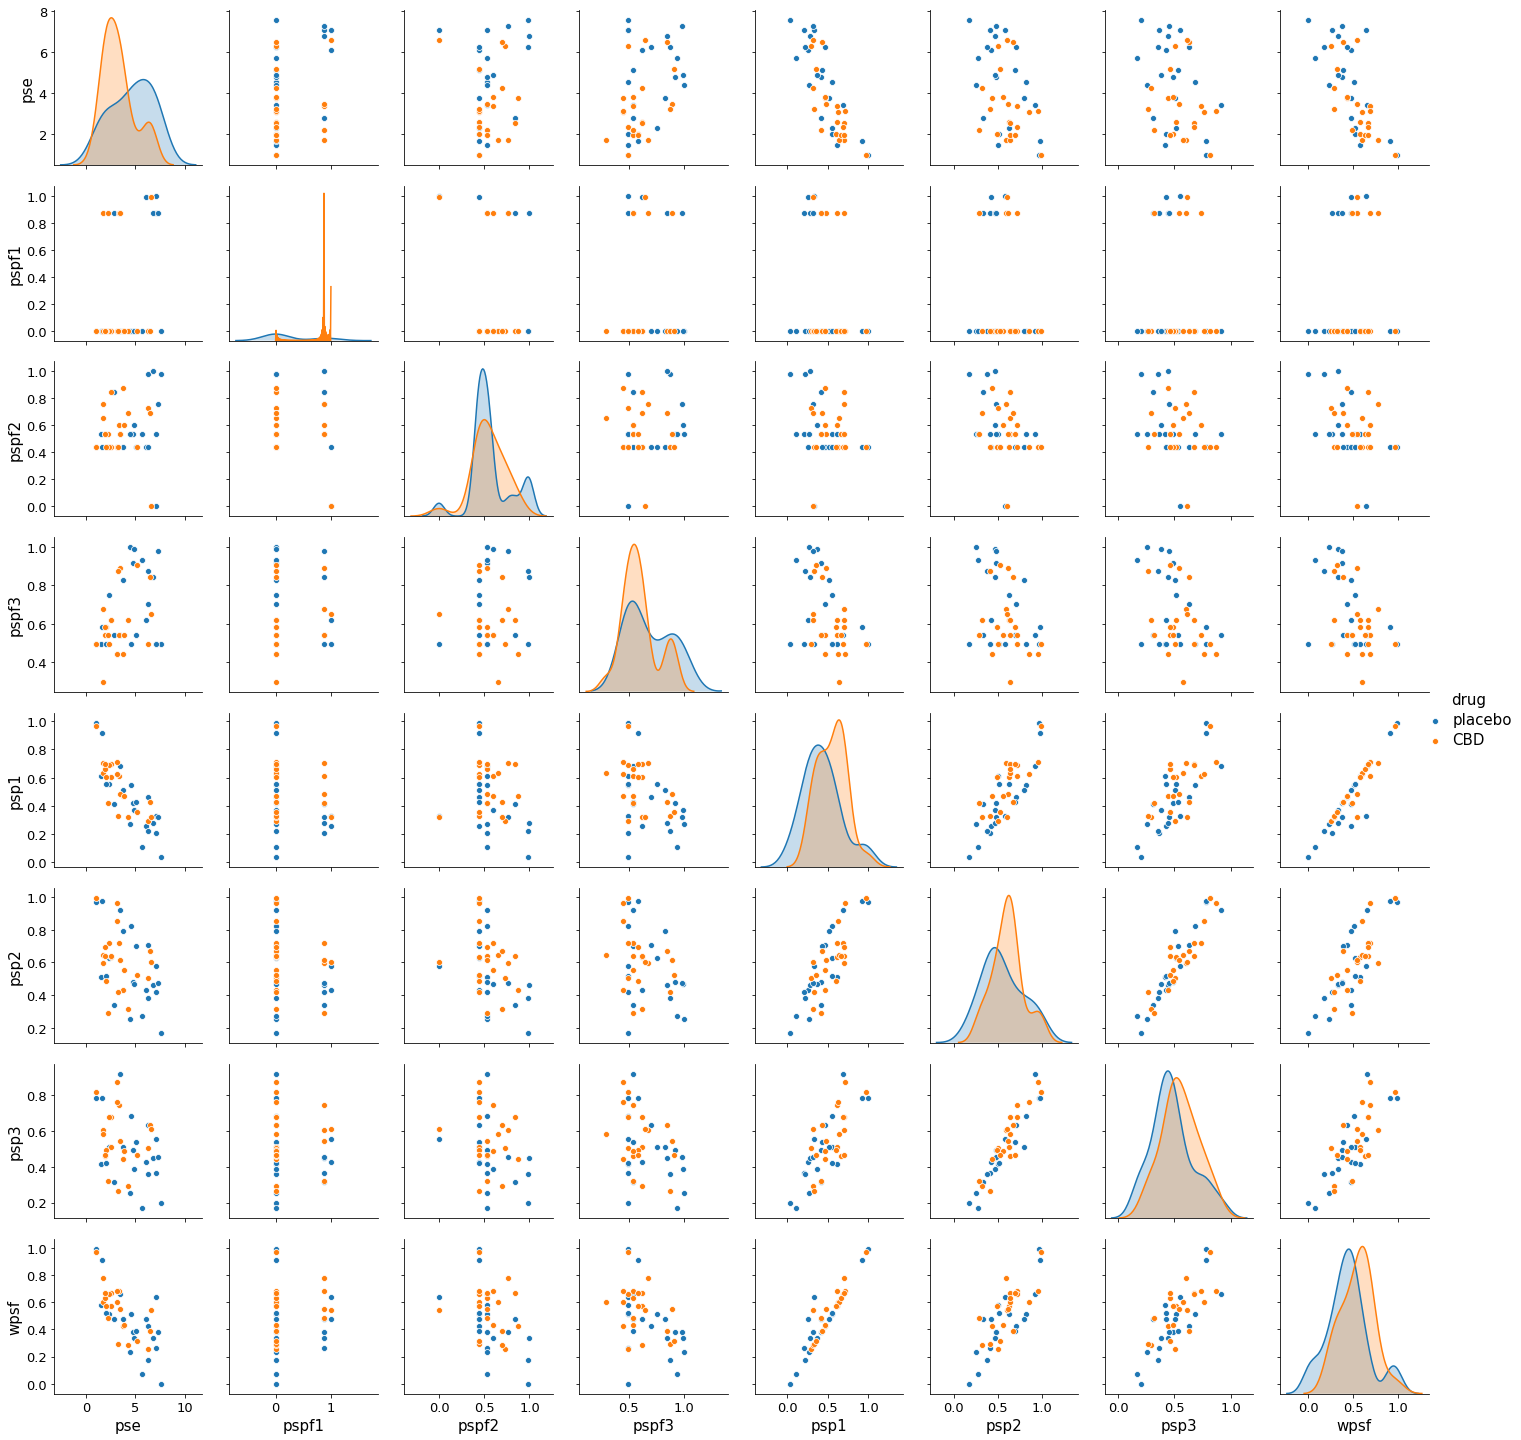

In [46]:
#Pairplot - medida S1
pairplot(df_measureS1,numeric_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


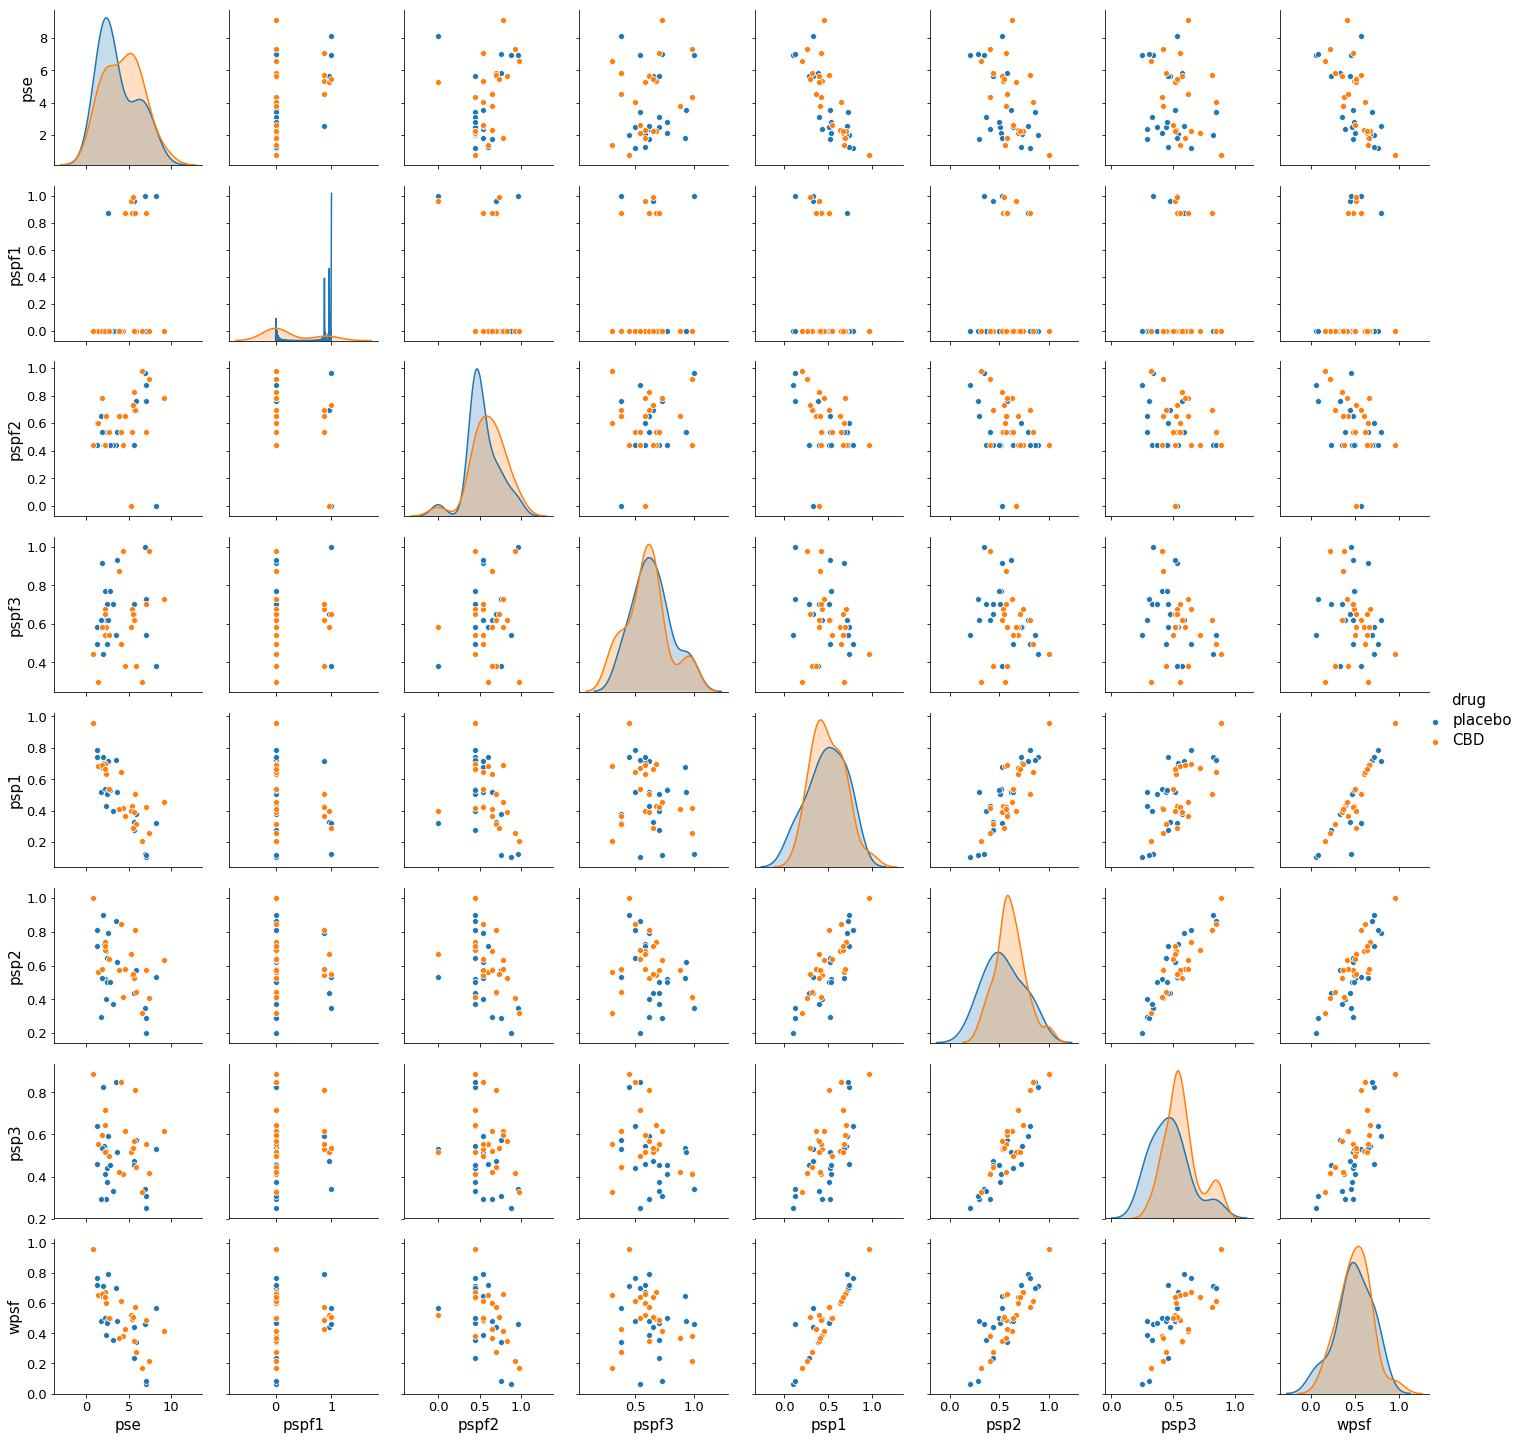

In [47]:
#Pairplot - medida S2
pairplot(df_measureS2,numeric_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


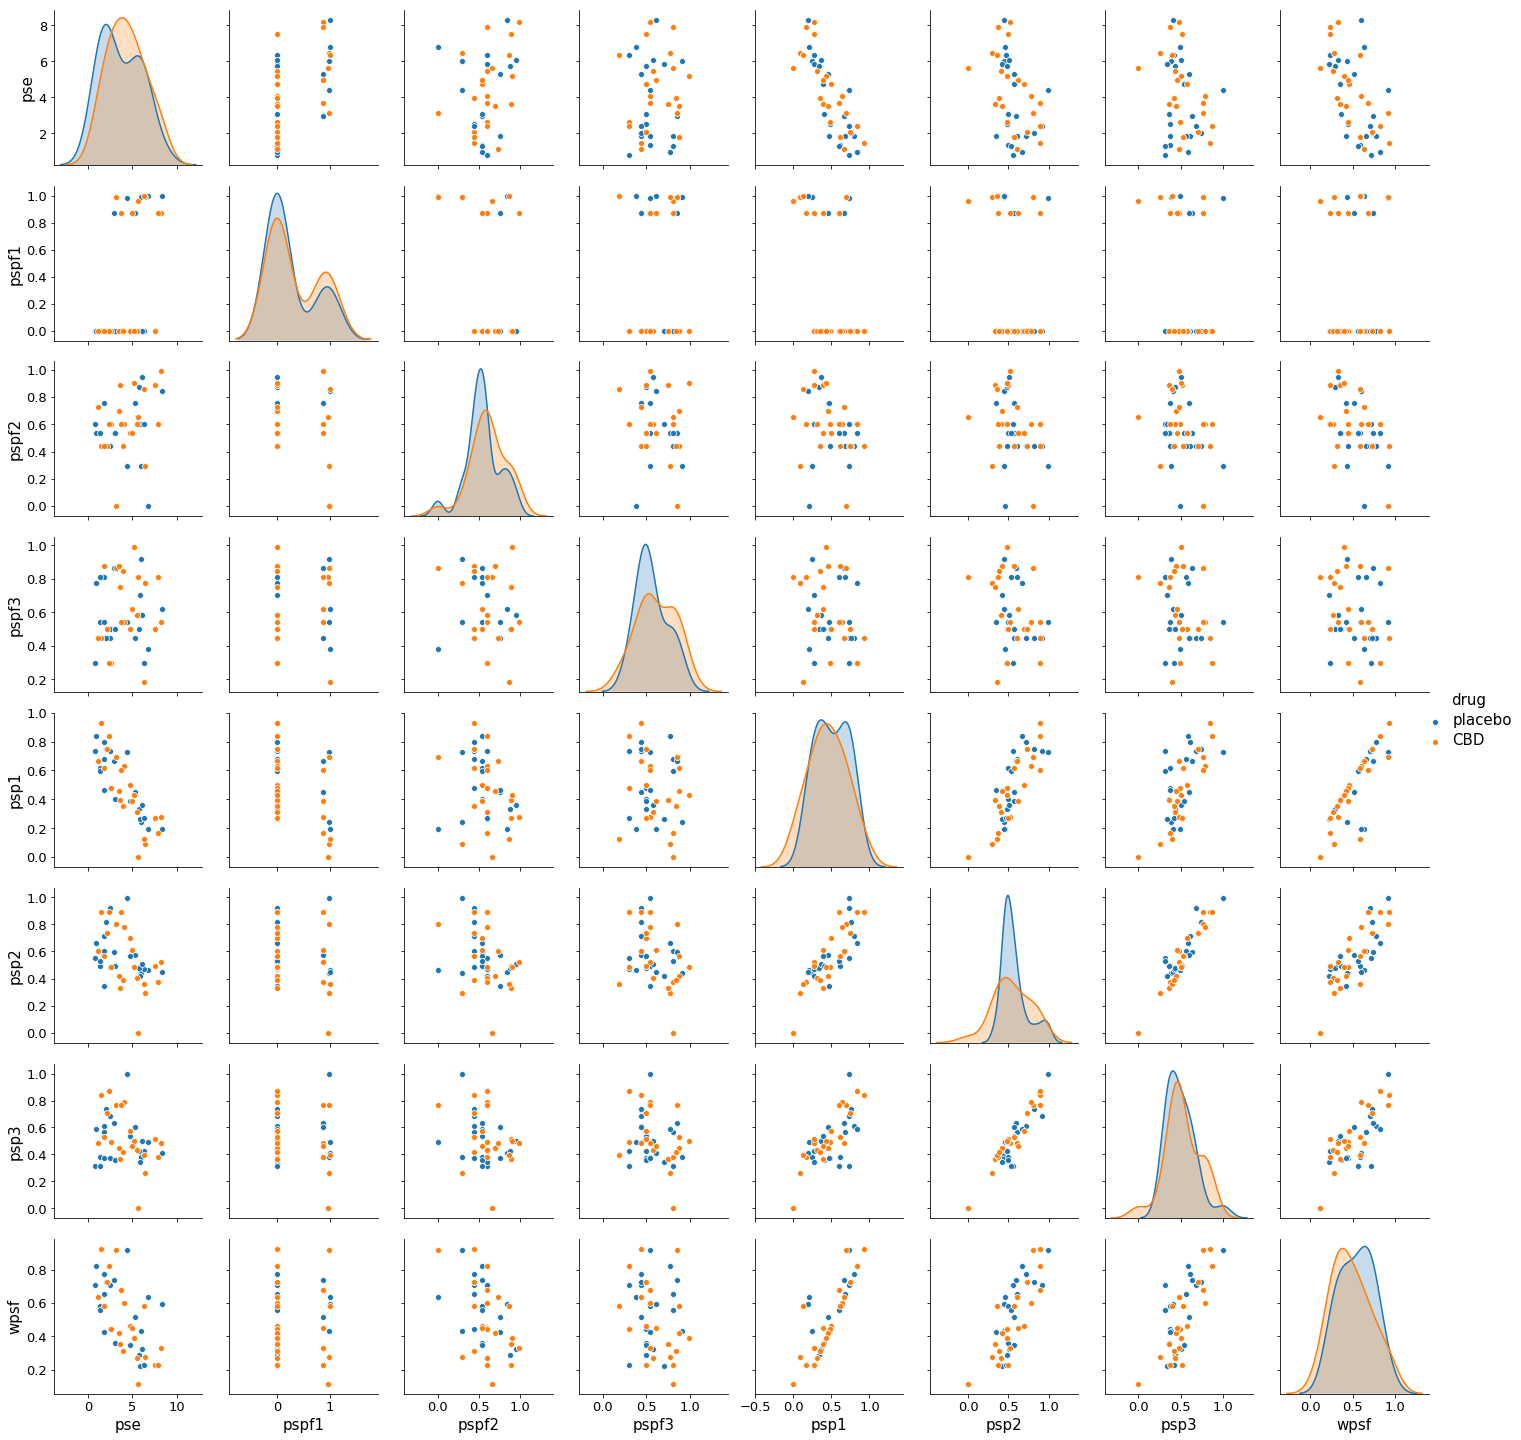

In [48]:
#Pairplot - medida F1
pairplot(df_measureF1,numeric_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


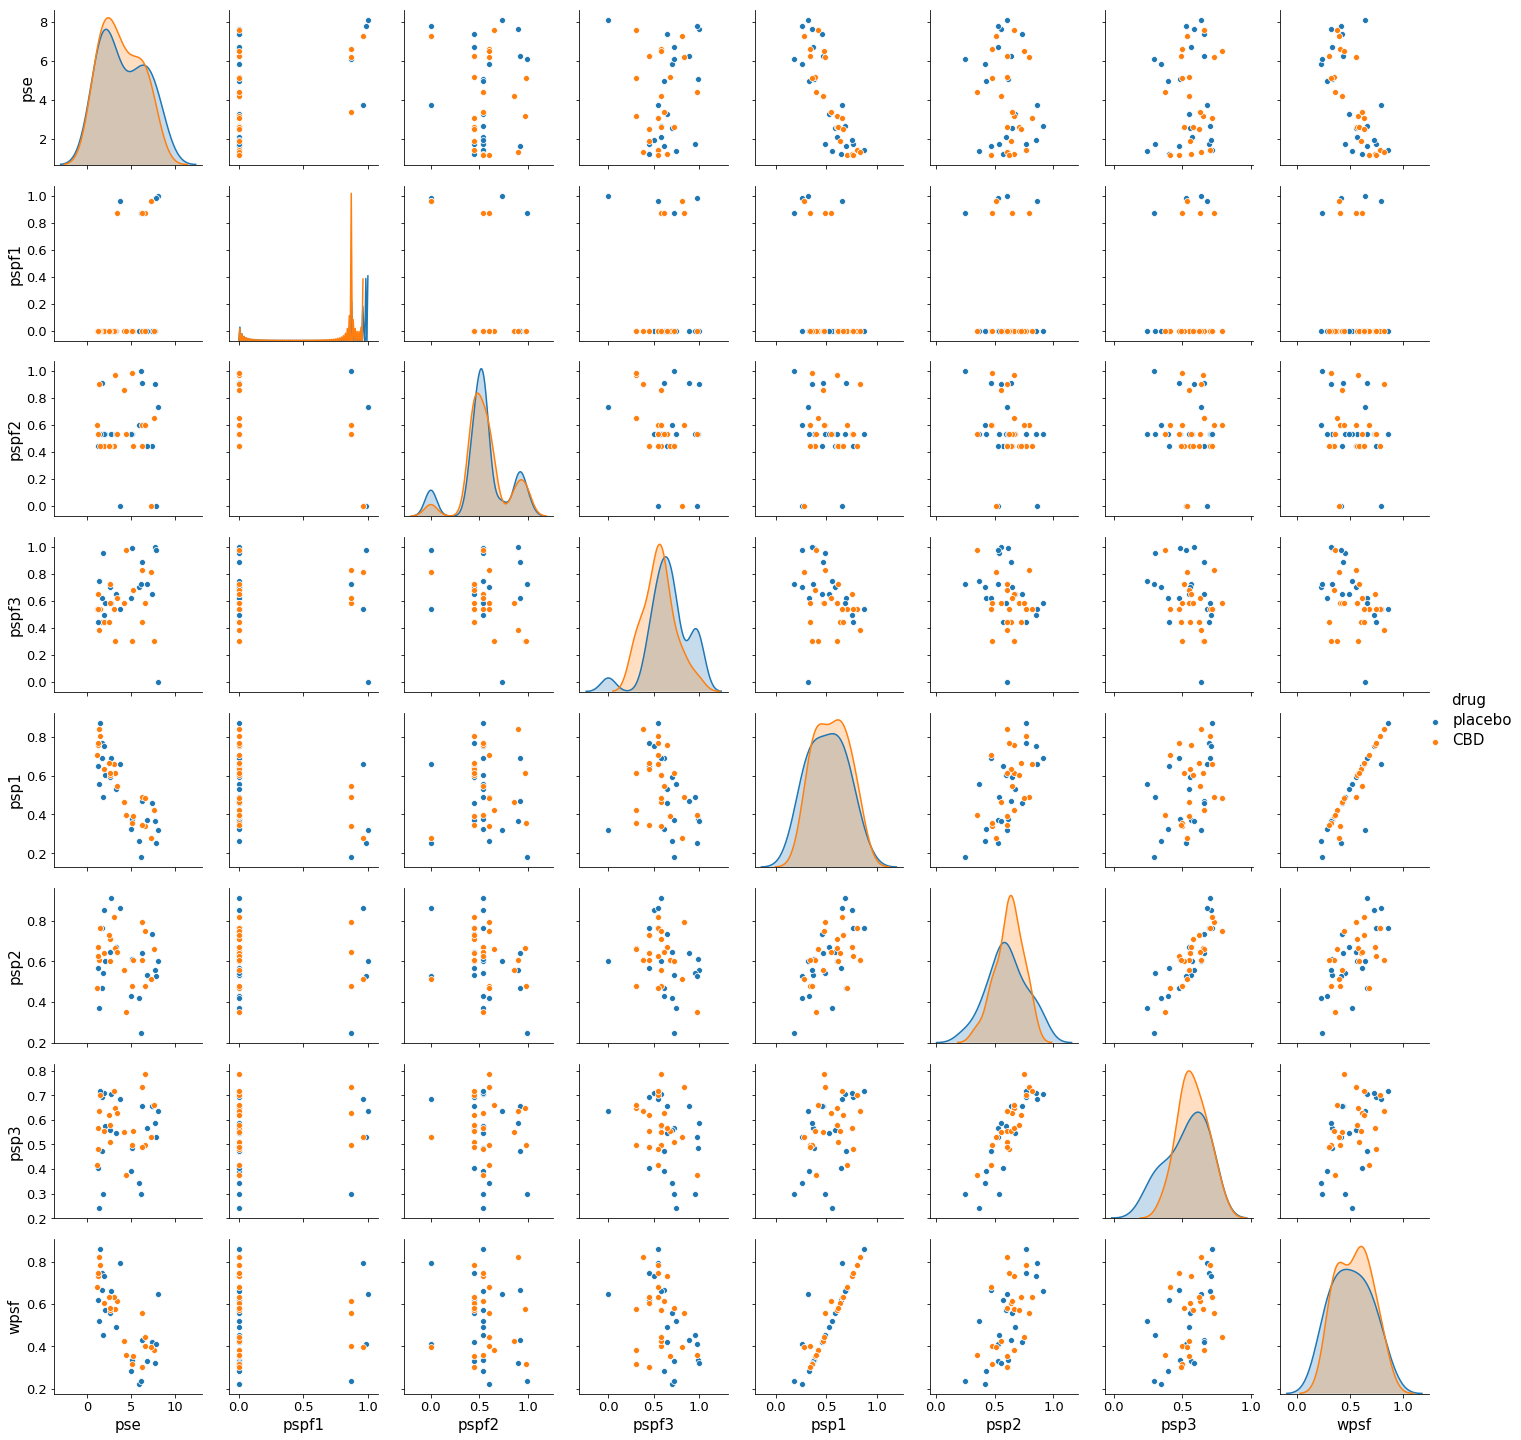

In [49]:
#Pairplot - medida F2
pairplot(df_measureF2,numeric_cols,'drug')

Pelos pairplot's não é possível verificar nenhum espaço que seja muito separável.

## 2.7 Análise dos dados divididos por tipo de medida e com métricas resumidas por amostra

Iremos utilizar o mesmo agrupamento anterior mas agora com as métricas resumidas ao longo das amostras com o mesmo objetivo de avaliar diferenças significativas.

In [50]:
#Dividindo dataset por medida
df_measureB = df_parkinson[df_parkinson['measure'] == 'B'].drop(columns=['measure','evaluate'])
df_measureP = df_parkinson[df_parkinson['measure'] == 'P'].drop(columns=['measure','evaluate'])
df_measureA = df_parkinson[df_parkinson['measure'] == 'A'].drop(columns=['measure','evaluate'])
df_measureS1 = df_parkinson[df_parkinson['measure'] == 'S1'].drop(columns=['measure','evaluate'])
df_measureS2 = df_parkinson[df_parkinson['measure'] == 'S2'].drop(columns=['measure','evaluate'])
df_measureF1 = df_parkinson[df_parkinson['measure'] == 'F1'].drop(columns=['measure','evaluate'])
df_measureF2 = df_parkinson[df_parkinson['measure'] == 'F2'].drop(columns=['measure','evaluate'])

In [51]:
#Calculando resumos para cada dataframe
for df in [df_measureB,df_measureP,df_measureA,df_measureS1,df_measureS2,df_measureF1,df_measureF2]:
    df['pspf_mean'] = df.apply(lambda x: x[['pspf1','pspf2','pspf3']].mean(),axis=1)
    df['pspf_std'] = df.apply(lambda x: x[['pspf1','pspf2','pspf3']].std(),axis=1)
    df['psp_mean'] = df.apply(lambda x: x[['psp1','psp2','psp3']].mean(),axis=1)
    df['psp_std'] = df.apply(lambda x: x[['psp1','psp2','psp3']].std(),axis=1)

    #Excluindo colunas desnecessarias
    df.drop(columns=['pspf1','pspf2','pspf3','psp1','psp2','psp3'],inplace=True)

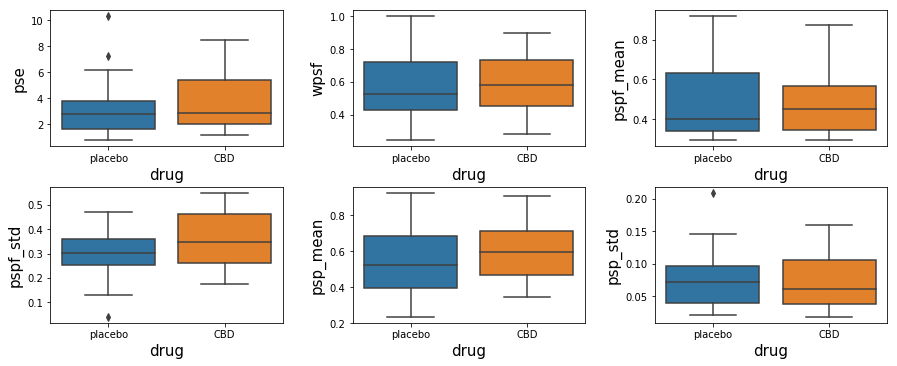

{'pse': 0.4151131363294269, 'wpsf': 0.6480224516517821, 'pspf_mean': 0.9230441708922889, 'pspf_std': 0.07860723350462791, 'psp_mean': 0.29215336952316445, 'psp_std': 0.7554189356432912}


In [52]:
#Colunas numericas
numeric_cols = df_measureB.drop(columns='drug').columns.values

#Boxplot - medida B
boxplot(df_measureB,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureB.loc[df_measureB['drug'] == 'placebo',numeric_cols],df_measureB.loc[df_measureB['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

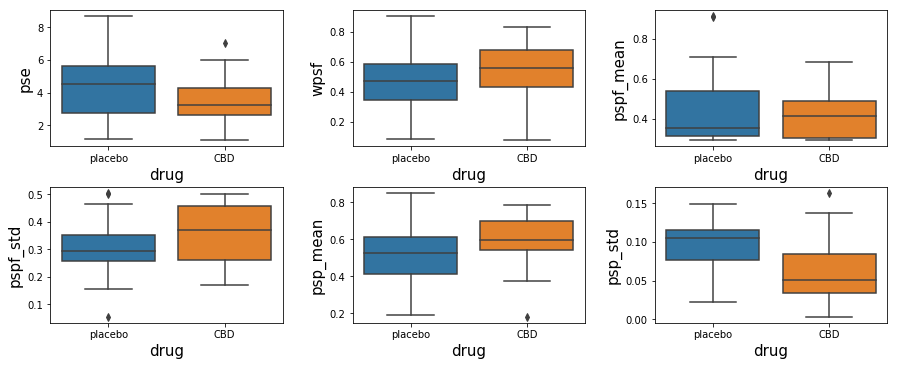

{'pse': 0.15361387526249176, 'wpsf': 0.20340583129688541, 'pspf_mean': 0.4419191734390917, 'pspf_std': 0.12251133380489623, 'psp_mean': 0.15880057148323598, 'psp_std': 0.014254397351340852}


In [53]:
#Boxplot - medida P
boxplot(df_measureP,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureP.loc[df_measureP['drug'] == 'placebo',numeric_cols],df_measureP.loc[df_measureP['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

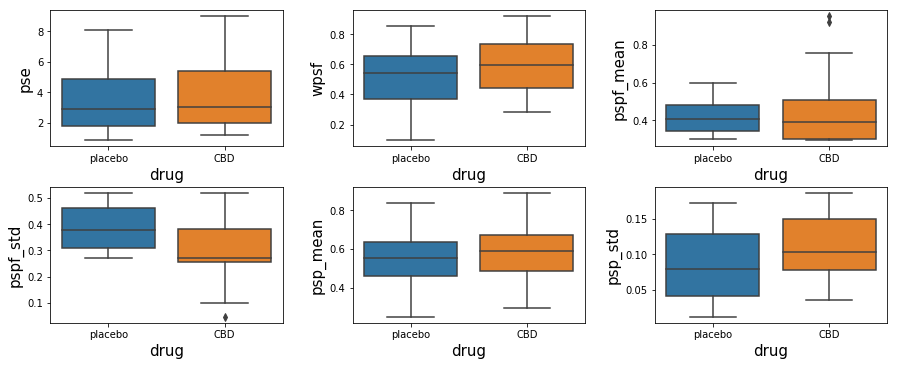

{'pse': 0.6264869234375883, 'wpsf': 0.2582204733386281, 'pspf_mean': 0.41371619501186707, 'pspf_std': 0.0054648453470081855, 'psp_mean': 0.25349231180340964, 'psp_std': 0.09430278971419155}


In [54]:
#Boxplot - medida A
boxplot(df_measureA,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureA.loc[df_measureA['drug'] == 'placebo',numeric_cols],df_measureA.loc[df_measureA['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

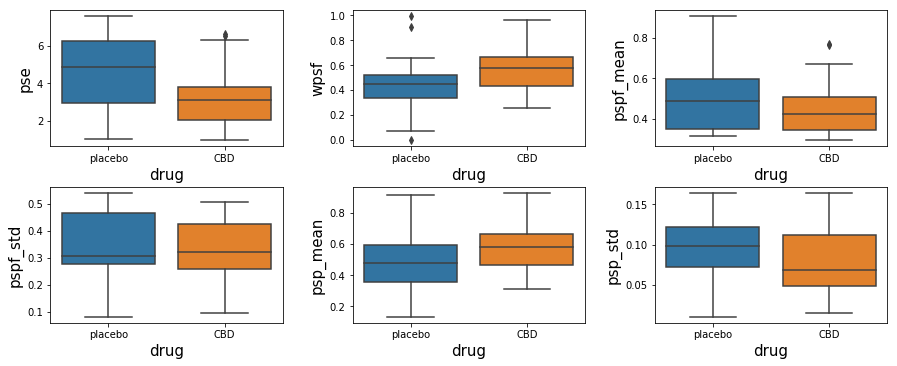

{'pse': 0.020753861337633475, 'wpsf': 0.09842686873986425, 'pspf_mean': 0.3143917512780111, 'pspf_std': 0.6118682150743855, 'psp_mean': 0.14640022114392906, 'psp_std': 0.17027827436261986}


In [55]:
#Boxplot - medida S1
boxplot(df_measureS1,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureS1.loc[df_measureS1['drug'] == 'placebo',numeric_cols],df_measureS1.loc[df_measureS1['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

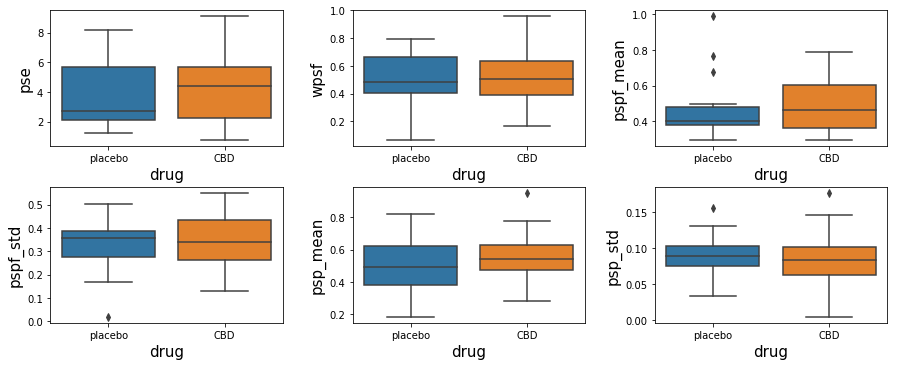

{'pse': 0.3263077033061125, 'wpsf': 0.8400690931503842, 'pspf_mean': 0.491912859569955, 'pspf_std': 0.8376707573519078, 'psp_mean': 0.23584391817850583, 'psp_std': 0.6621697261559674}


In [56]:
#Boxplot - medida S2
boxplot(df_measureS2,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureS2.loc[df_measureS2['drug'] == 'placebo',numeric_cols],df_measureS2.loc[df_measureS2['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

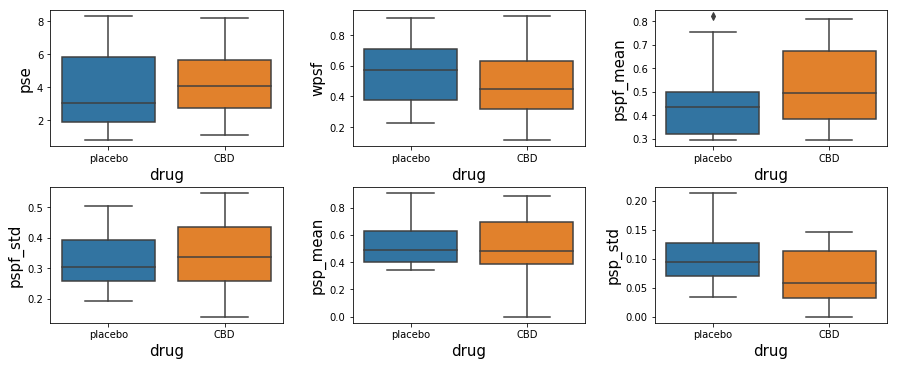

{'pse': 0.3533847466749498, 'wpsf': 0.37971989245210813, 'pspf_mean': 0.2193314035660564, 'pspf_std': 0.8039367678787923, 'psp_mean': 0.7350418345182829, 'psp_std': 0.03677775027998075}


In [57]:
#Boxplot - medida F1
boxplot(df_measureF1,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureF1.loc[df_measureF1['drug'] == 'placebo',numeric_cols],df_measureF1.loc[df_measureF1['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

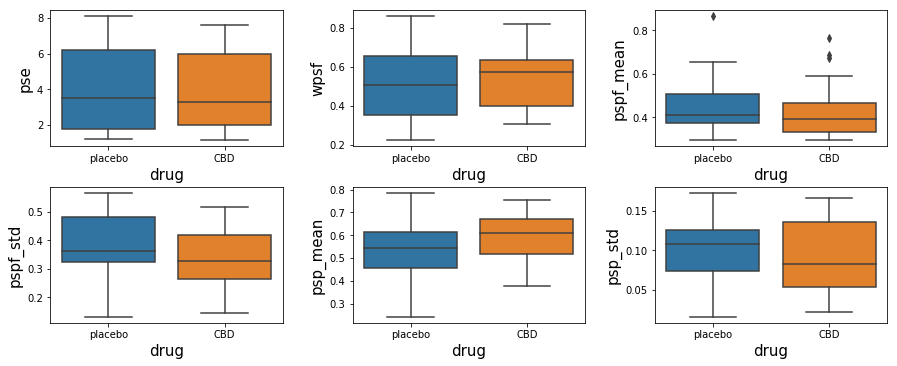

{'pse': 0.6858456124394099, 'wpsf': 0.5999107005824185, 'pspf_mean': 0.45046439556155515, 'pspf_std': 0.1456894202657659, 'psp_mean': 0.3617035739841499, 'psp_std': 0.5719731145614443}


In [58]:
#Boxplot - medida F2
boxplot(df_measureF2,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureF2.loc[df_measureF2['drug'] == 'placebo',numeric_cols],df_measureF2.loc[df_measureF2['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

Mesmas conclusões para as medidas calculadas no tópico 2.6

# 3. Conclusões

- Sem nenhum tratamento nos dados provavelmente não será possível usar nenhum algoritmo de machine learning.
- Na forma como eles estão, não há diferenças significativas entre os grupos divididos por tipo de droga.
- Usar sumarização nos dados temporais pode ser uma boa ideia como médio e desvio padrão em conjunto por apararentemente gerar espaços mais separaveis.
- Lembrando que ao realizar resumos nas métricas estaremos diminuindo o número de amostras.
- Realizar resumos por amostra não parece ser interessante por não ter produzido resultados interessantes.
- Dependendo da fase as conclusões para um mesmo atributo pode ser diferente pois quando voce analisa os boxplot's temos que 'shift's diferentes. Além disso, temos que há fases na qual as diferenças aparenta ser mais significativa. Portanto, pode ser interessante gerar variáveis dummies que indiquem qual o tipo de fase a pessoa se encontra.